In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import IPython
IPython.display.Audio("ibeep.mp3",autoplay=True)

In [3]:
import numpy as np
np.set_printoptions(linewidth=np.inf)
import sympy as sp
import scipy as sc
from colorednoise import powerlaw_psd_gaussian as cn
from scipy import integrate,signal,stats,io
from sklearn.linear_model import Lasso,ridge_regression
from sklearn.utils.extmath import weighted_mode

from matplotlib import pyplot as plt
from mpl_toolkits import mplot3d
%matplotlib inline

import pysindy as ps

from tqdm import tqdm,tnrange

import copy

from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

C:\Users\rautj\Anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\rautj\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
C:\Users\rautj\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  stacklevel=1)


In [4]:
from sindy_functions import *
from systems import *

In [5]:
#Damaged bearing - normalised

In [6]:
#Bearing outer race fault - like signal generator

def ims_det(tlim,dt=1/20480,ff=1/200,m=1,k=1e9,c=2e3,famp=1,fsqr=2):
    
    """
    Bearing outer race fault - like signal generator
    
    Inputs: (tlim, dt=0.01, ff=5, m=1, k=1000, c=10, iscale=1)
    Retruns: (time stamps, actual system state, system & signal properties)
    """
    
    def F(t):
        r=np.exp(-((t%(ff)-(2e-4))*2e4)**fsqr)*famp
        return r
    
    mkc=tuple([m,k,c])
    
    def smd(x,t,m,k,c):
        dx=[x[1],
            F(t)/m-(k*x[0]+c*x[1])/m]
        return dx

    tstamps=np.arange(0,tlim,dt)
    x0=[0,0]
    
    sol=sc.integrate.odeint(smd,x0,tstamps,args=mkc,rtol=1e-12,atol=1e-12)
    Sol=sol.T
    
    return tstamps, Sol, (dt,ff,m,k,c)

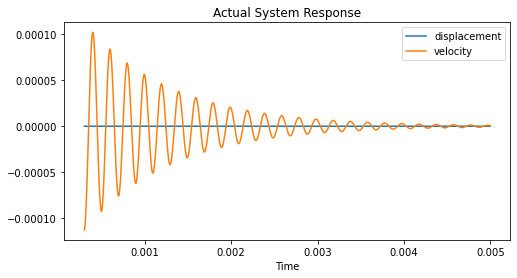

In [7]:
stlim=0.005
tstamps,Sol,_=ims_det(stlim,dt=1/1000000,famp=2,fsqr=10)
dt=_[0]
Soldt=np.gradient(Sol.T[:,:],dt,axis=0).T
sf=1/dt

Sol=Sol[:,int(3e-4/dt):]
tstamps=tstamps[int(3e-4/dt):]

plt.figure(figsize=(8, 4))
plt.title('Actual System Response')
plt.xlabel('Time')
plt.plot(tstamps,Sol[0,:],label='displacement')
plt.plot(tstamps,Sol[1,:],label='velocity')
plt.legend()
plt.show()

In [8]:
nc=np.abs(Sol.T).max(axis=0)
print('initial variable normalisation constants (division):',nc)

initial variable normalisation constants (division): [3.38672497e-09 1.12509902e-04]


In [9]:
#x, x' normalisation - noise free

midpoint=np.array([0,0])
#midpoint=np.average(Sol,axis=1)
#midpoint=(np.max(Sol,axis=1)+np.min(Sol,axis=1))/2
print('initial midpoint:',midpoint)
Solm=Sol-np.reshape(midpoint,(-1,1))

nc=np.abs(Solm.T).max(axis=0)
nc=np.array([3.38511851e-09, 1.12509898e-04])
print('initial variable normalisation constants (division):',nc)
nSol=Solm.T/nc
nSol=nSol.T
nSolnf=np.copy(nSol)
nSolnfdt=np.gradient(nSolnf[:,:],dt,axis=1)

#noise addition
#np.random.seed(1)
nlevel=0.02
#nSol=np.random.normal(nSol,nlevel/2)
nSol[0]=nSol[0]+nlevel/2*cn(0,len(nSol[0]))
#nlevel=0.02
#nSol=np.random.normal(nSol,nlevel/2)
nSol[1]=nSol[1]+nlevel/2*cn(0,len(nSol[1]))

#nSol=np.random.normal(nSol,nlevel/2)

#implied noisy measurements - unnormalised
uSol=(nSol.T*nc).T+np.reshape(midpoint,(-1,1))
uSoldt=np.gradient(uSol[:,:],dt,axis=1)

#x, x' normalisation - with noise

midpoint=np.array([0,0])
#midpoint=np.average(Sol,axis=1)
#midpoint=(np.max(uSol,axis=1)+np.min(uSol,axis=1))/2
print('midpoint:',midpoint)
uSolm=uSol-np.reshape(midpoint,(-1,1))

nc=np.abs(uSolm.T).max(axis=0)
nc=np.array([3.38511851e-09, 1.12509898e-04])
print('variable normalisation constants (division):',nc)
nSol=uSolm.T/nc
nSol=nSol.T
nSoldt=np.gradient(nSol[:,:],dt,axis=1)

initial midpoint: [0 0]
initial variable normalisation constants (division): [3.38511851e-09 1.12509898e-04]
midpoint: [0 0]
variable normalisation constants (division): [3.38511851e-09 1.12509898e-04]


In [10]:
deg=3
thres=1500
mc=SINDy(polypool(nSolnf[:,:].T,deg),nSolnfdt.T,thres,reg=1e-16,normalise='auto')
names=polypool_names(['x','y'],deg)
dispmymod(mc,['x\'','y\''],names)
corr=np.nan_to_num(mc/mc)
#corr=np.copy(mc)
#corr

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

C:\Users\rautj\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


In [11]:
STSRATE=[]
optthress=[]

thress=np.linspace(100,1800,10)
nlevels=np.linspace(0.0,0.1,11)

for a in tnrange(100):
    stsrate=[]
    optthres=np.nan*np.ones_like(nlevels)
    for inlevel in range(len(nlevels)):
        midpoint=np.array([0,0])
        Solm=Sol-np.reshape(midpoint,(-1,1))

        nc=np.abs(Solm.T).max(axis=0)
        nc=np.array([3.38511851e-09, 1.12509898e-04])
        nSol=Solm.T/nc
        nSol=nSol.T
        nSolnf=np.copy(nSol)
        nSolnfdt=np.gradient(nSolnf.T[:,:],dt,axis=0).T

        nlevel=nlevels[inlevel]
        nSol[0]=nSol[0]+nlevel/2*cn(0,len(nSol[0]))
        nSol[1]=nSol[1]+nlevel/2*cn(0,len(nSol[1]))
        

        uSol=(nSol.T*nc).T+np.reshape(midpoint,(-1,1))
        uSoldt=np.gradient(uSol.T[:,:],dt,axis=0).T

        midpoint=np.array([0,0])
        uSolm=uSol-np.reshape(midpoint,(-1,1))

        nc=np.abs(uSolm.T).max(axis=0)
        nc=np.array([3.38511851e-09, 1.12509898e-04])
        nSol=uSolm.T/nc
        nSol=nSol.T
        nSoldt=np.gradient(nSol.T[:,:],dt,axis=0).T

        success=False
        for ithres in range(len(thress)):
            if not success:
                mc=SINDy(np.nan_to_num(polypool(nSol[:,:].T,deg)),nSoldt[:,:].T,thress[ithres],reg=1e-16,normalise='auto')
                if np.all(np.nan_to_num(mc/mc)==corr):
                    success=True
                    optthres[inlevel]=thress[ithres]
        stsrate.append(success)
    optthress.append(optthres)
    
    STSRATE.append(stsrate)

C:\Users\rautj\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  import sys


  0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\rautj\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in true_divide


KeyboardInterrupt: 

In [ ]:
ESRATE=[]

optthres=np.nan_to_num(np.nansum(optthress,axis=0)/np.nansum(np.abs(np.array(optthress)/np.array(optthress)),axis=0), nan=1.8e3)

for a in tnrange(100):
    esrate=[]
    for inlevel in range(len(nlevels)):
        midpoint=np.array([0,0])
        Solm=Sol-np.reshape(midpoint,(-1,1))

        nc=np.abs(Solm.T).max(axis=0)
        nc=np.array([3.38511851e-09, 1.12509898e-04])
        nSol=Solm.T/nc
        nSol=nSol.T
        nSolnf=np.copy(nSol)
        nSolnfdt=np.gradient(nSolnf.T[:,:],dt,axis=0).T

        nlevel=nlevels[inlevel]
        nSol[0]=nSol[0]+nlevel/2*cn(0,len(nSol[0]))
        nSol[1]=nSol[1]+nlevel/2*cn(0,len(nSol[1]))

        uSol=(nSol.T*nc).T+np.reshape(midpoint,(-1,1))
        uSoldt=np.gradient(uSol.T[:,:],dt,axis=0).T

        midpoint=np.array([0,0])
        uSolm=uSol-np.reshape(midpoint,(-1,1))

        nc=np.abs(uSolm.T).max(axis=0)
        nc=np.array([3.38511851e-09, 1.12509898e-04])
        nSol=uSolm.T/nc
        nSol=nSol.T
        nSoldt=np.gradient(nSol.T[:,:],dt,axis=0).T

        success=False
        for incp in np.arange(0.1,1,0.1):
            if not success:
                mc=ESINDy(polypool(nSol[:,:].T,deg),nSoldt[:,:].T,optthres[inlevel],100,0.632,1e-16,incp,normalise='auto')
                if np.all(np.nan_to_num(mc/mc)==corr):
                    success=True
        esrate.append(success)
    
    ESRATE.append(esrate)

In [ ]:
CVSRATE=[]

ptfs=np.linspace(0.001,0.03,10)
#ptfs[0]=0.2

for a in tnrange(100):
    cvsrate=[]
    for inlevel in range(len(nlevels)):
        midpoint=np.array([0,0])
        Solm=Sol-np.reshape(midpoint,(-1,1))

        nc=np.abs(Solm.T).max(axis=0)
        nc=np.array([3.38511851e-09, 1.12509898e-04])
        nSol=Solm.T/nc
        nSol=nSol.T
        nSolnf=np.copy(nSol)
        nSolnfdt=np.gradient(nSolnf.T[:,:],dt,axis=0).T

        nlevel=nlevels[inlevel]
        nSol[0]=nSol[0]+nlevel/2*cn(0,len(nSol[0]))
        nSol[1]=nSol[1]+nlevel/2*cn(0,len(nSol[1]))

        uSol=(nSol.T*nc).T+np.reshape(midpoint,(-1,1))
        uSoldt=np.gradient(uSol.T[:,:],dt,axis=0).T

        midpoint=np.array([0,0])
        uSolm=uSol-np.reshape(midpoint,(-1,1))

        nc=np.abs(uSolm.T).max(axis=0)
        nc=np.array([3.38511851e-09, 1.12509898e-04])
        nSol=uSolm.T/nc
        nSol=nSol.T
        nSoldt=np.gradient(nSol.T[:,:],dt,axis=0).T

        success=False
        for iptf in range(len(ptfs)):
            if not success:
                mc=SINDyCV_t(polypool(nSol[:,:].T,deg),nSoldt[:,:].T,0.01,1e-16,1e-16,0,10,ptf=ptfs[iptf],normalise='auto')
                if np.all(np.nan_to_num(mc/mc)==corr):
                    success=True
        cvsrate.append(success)
    
    CVSRATE.append(cvsrate)

In [ ]:
CVSTSRATE=[]

for a in tnrange(100):
    cvstsrate=[]
    for inlevel in range(len(nlevels)):
        midpoint=np.array([0,0])
        Solm=Sol-np.reshape(midpoint,(-1,1))

        nc=np.abs(Solm.T).max(axis=0)
        nc=np.array([3.38511851e-09, 1.12509898e-04])
        nSol=Solm.T/nc
        nSol=nSol.T
        nSolnf=np.copy(nSol)
        nSolnfdt=np.gradient(nSolnf.T[:,:],dt,axis=0).T

        nlevel=nlevels[inlevel]
        nSol[0]=nSol[0]+nlevel/2*cn(0,len(nSol[0]))
        nSol[1]=nSol[1]+nlevel/2*cn(0,len(nSol[1]))

        uSol=(nSol.T*nc).T+np.reshape(midpoint,(-1,1))
        uSoldt=np.gradient(uSol.T[:,:],dt,axis=0).T

        midpoint=np.array([0,0])
        uSolm=uSol-np.reshape(midpoint,(-1,1))

        nc=np.abs(uSolm.T).max(axis=0)
        nc=np.array([3.38511851e-09, 1.12509898e-04])
        nSol=uSolm.T/nc
        nSol=nSol.T
        nSoldt=np.gradient(nSol.T[:,:],dt,axis=0).T

        success=False
        for iptf in range(len(ptfs)):
            if not success:
                mc0=SINDyCV_t(polypool(nSol[:,:].T,deg),nSoldt[:,:].T,0.01,1e-0,1e-0,0,10,ptf=ptfs[iptf],normalise='auto')
                for ithres in range(len(thress)):
                    mc=re_SINDy(polypool(nSol[:,:].T,deg),nSoldt[:,:].T,copy.deepcopy(mc0),thress[ithres],reg=1e-16,normalise='auto')
                    if np.all(np.nan_to_num(mc/mc)==corr):
                        success=True
        cvstsrate.append(success)
    
    CVSTSRATE.append(cvstsrate)

In [ ]:
plt.figure(figsize=(12,3))
plt.title('Success rate of normalised Bearing Housing model form identificaton')
plt.xlabel('noise level')
plt.plot(nlevels,np.average(np.array(STSRATE),axis=0),'1-',markersize=12,label='STLSQ')
plt.plot(nlevels,np.average(np.array(ESRATE),axis=0),'4-',markersize=12,label='E-SINDy')
plt.plot(nlevels,np.average(np.array(CVSRATE),axis=0),'2-',markersize=12,label='STCV')
plt.plot(nlevels,np.average(np.array(CVSTSRATE),axis=0),'3-',markersize=12,label='STCV + STLSQ')
plt.legend()
plt.show()

In [ ]:
np.vstack((np.average(np.array(STSRATE),axis=0),np.average(np.array(ESRATE),axis=0),np.average(np.array(CVSRATE),axis=0),np.average(np.array(CVSTSRATE),axis=0)))

In [ ]:
#np.savetxt('bearingnorm.stcv',np.vstack((np.average(np.array(STSRATE),axis=0),np.average(np.array(ESRATE),axis=0),np.average(np.array(CVSRATE),axis=0),np.average(np.array(CVSTSRATE),axis=0))))

In [12]:
np.loadtxt('bearingnorm.stcv')

array([[1.  , 1.  , 1.  , 0.86, 0.52, 0.16, 0.06, 0.03, 0.  , 0.  , 0.02],
       [1.  , 1.  , 0.99, 0.83, 0.4 , 0.26, 0.2 , 0.07, 0.04, 0.01, 0.02],
       [0.  , 1.  , 1.  , 1.  , 0.97, 0.95, 0.9 , 0.83, 0.75, 0.51, 0.36],
       [1.  , 1.  , 1.  , 1.  , 0.98, 0.98, 0.88, 0.82, 0.64, 0.53, 0.38]])

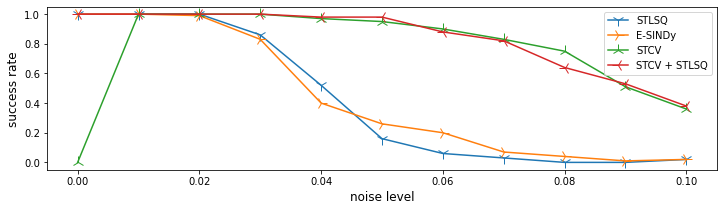

In [13]:
plt.figure(figsize=(12,3))
plt.ylabel('success rate',fontsize=12)
plt.xlabel('noise level',fontsize=12)
plt.plot(nlevels,np.loadtxt('bearingnorm.stcv')[0],'1-',markersize=12,label='STLSQ')
plt.plot(nlevels,np.loadtxt('bearingnorm.stcv')[1],'4-',markersize=12,label='E-SINDy')
plt.plot(nlevels,np.loadtxt('bearingnorm.stcv')[2],'2-',markersize=12,label='STCV')
plt.plot(nlevels,np.loadtxt('bearingnorm.stcv')[3],'3-',markersize=12,label='STCV + STLSQ')
#plt.xticks(nlevels[::2],['']*6)
plt.legend()
plt.show()

In [14]:
#linear half car

In [15]:
def lhcm(tlim,dt=0.01,bf=10,P=tuple([600,730,45,45,1.5,1.15,18000,500,18000,500,102017.2,128])):
    
    """
    """
    
    def F(t):
        f=np.zeros(8).reshape(-1,1)
        if t%bf<0.0105:
            f[5,0]=0.1
        if (t-0.1)%bf<0.0105:
            f[7,0]=0.1
        return f
    
    def sys(t,x,ms,js,mf,mr,l1,l2,kf,cf,kr,cr,kt,ct):
        
        A=np.array([[x[1]]
                   ,[kf*(-x[0]+x[4]-x[2]*l1)+cf*(-x[1]+x[5]-x[3]*l1)+kr*(-x[0]+x[6]+x[2]*l2)+cr*(-x[1]+x[7]+x[3]*l2)]
                   ,[x[3]]
                   ,[l1*(kf*(-x[0]+x[4]-x[2]*l1)+cf*(-x[1]+x[5]-x[3]*l1))+l2*(kr*(x[0]-x[6]-x[2]*l2)+cr*(x[1]-x[7]-x[3]*l2))]
                   ,[x[5]]
                   ,[kf*(x[0]-x[4]+x[2]*l1)+cf*(x[1]-x[5]+x[3]*l1)+kt*(-x[4])+ct*(-x[5])]
                   ,[x[7]]
                   ,[kr*(x[0]-x[6]-x[2]*l2)+cr*(x[1]-x[7]-x[3]*l2)+kt*(-x[6])+ct*(-x[7])]])
        M=np.array([[1]
                   ,[ms]
                   ,[1]
                   ,[js]
                   ,[1]
                   ,[mf]
                   ,[1]
                   ,[mr]])
        B=np.diag([0,0,0,0,0,kt,0,kt])
        
        dx=(A+B@F(t))/M
        return dx.reshape(1,-1).tolist()[0]

    tstamps=np.arange(0,tlim,dt)
    x0=[0,0,0,0,0,0,0,0]
    #x0=np.random.normal(size=8)*0.1
    
    #sol=sc.integrate.odeint(sys,x0,tstamps,args=P,rtol=1e-12,atol=1e-12);Sol=sol.T
    sol=sc.integrate.solve_ivp(sys,[0,tlim],x0,t_eval=tstamps,args=P,method='Radau',max_step=1e-3,rtol=1e-12,atol=1e-12).y;Sol=sol
    
    FF=[]
    for t in tstamps:
        FF.append(F(t))
    
    return tstamps, Sol, (dt,bf,P,FF)

C:\Users\rautj\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log10
  


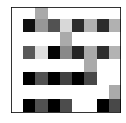

# terms 32


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

C:\Users\rautj\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide


In [16]:
Ms,J,Mwf,Mwr,a,b,Ksf,Csf,Ksr,Csr,Kwf,Cwf=tuple([600,730,45,45,1.5,1.15,18000,500,18000,500,102017.2,128])
Kwr,Cwr=[Kwf,Cwf]
#Ms,J,Mwf,Mwr,Ksf,Ksr,Csf,Csr,Kwf,Kwr,Cwf,Cwr,a,b=tuple([600,730,45,45,18000,18000,500,500,102017.2,102017.2,128,128,1.5,1.15])

A=np.array([[0,1,0,0,0,0,0,0]
           ,[(-Ksf-Ksr)/Ms,(-Csf-Csr)/Ms,(-Ksf*a+Ksr*b)/Ms,(-Csf*a+Csr*b)/Ms,Ksf/Ms,Csf/Ms,Ksr/Ms,Csr/Ms]
           ,[0,0,0,1,0,0,0,0]
           ,[(-Ksf*a+Ksr*b)/J,(-Csf*a+Csr*b)/J,(-Ksf*a*a-Ksr*b*b)/J,(-Csf*a*a-Csr*b*b)/J,Ksf*a/J,Csf*a/J,-Ksr*b/J,-Csr*b/J]
           ,[0,0,0,0,0,1,0,0]
           ,[Ksf/Mwf,Csf/Mwf,Ksf*a/Mwf,Csf*a/Mwf,(-Kwf-Ksf)/Mwf,(-Cwf-Csf)/Mwf,0,0]
           ,[0,0,0,0,0,0,0,1]
           ,[Ksr/Mwr,Csr/Mwr,-Ksr*b/Mwr,-Csr*b/Mwr,0,0,(-Kwr-Ksr)/Mwr,(-Cwr-Csr)/Mwr]])
A_=np.hstack((np.zeros((8,1)),A))

plt.figure(figsize=(2,2))
plt.imshow(np.log10(np.abs(A_)),cmap='gray_r',aspect='auto',vmin=-1,vmax=2)
plt.tight_layout()
plt.xticks([])
plt.yticks([])
plt.show()

print('# terms',(np.abs(A)>0).sum())

names=polypool_names_(['x_0','x_1','x_2','x_3','x_4','x_5','x_6','x_7'],1)
dispmymod(A_.T,['x_0\'','x_1\'','x_2\'','x_3\'','x_4\'','x_5\'','x_6\'','x_7\''],names)

corr=np.nan_to_num(A_.T/A_.T)

In [17]:
tstamps,Sol,_=lhcm(tlim=2.12,dt=2e-4)
dt=_[0]
sf=1/dt
Sol=Sol[:,int(0.12/dt):]
tstamps=tstamps[int(0.12/dt):]
Soldt=np.gradient(Sol.T[:,:],dt,axis=0).T

#deflection signals
dxc=np.vstack((-Sol[0]+Sol[4]-Sol[2]*a,-Sol[1]+Sol[5]-Sol[3]*a,-Sol[0]+Sol[6]+Sol[2]*b,-Sol[1]+Sol[7]+Sol[3]*b))
dthetac=np.vstack((-Sol[0]+Sol[4]-Sol[2]*a,-Sol[1]+Sol[5]-Sol[3]*a,Sol[0]-Sol[6]-Sol[2]*b,Sol[1]-Sol[7]-Sol[3]*b))
dxf=np.vstack((Sol[0]-Sol[4]+Sol[2]*a,Sol[1]-Sol[5]+Sol[3]*a,-Sol[4],-Sol[5]))
dxr=np.vstack((Sol[0]-Sol[6]-Sol[2]*b,Sol[1]-Sol[7]-Sol[3]*b,-Sol[6],-Sol[7]))

#normalisation - noise free
nc=np.abs(Soldt.T).max(axis=0);nSoldt=Soldt.T/nc;nSoldt=nSoldt.T;nSoldtnf=np.copy(nSoldt)

ncdxc=np.abs(dxc.T).max(axis=0);ndxc=dxc.T/ncdxc;ndxc=ndxc.T;ndxcnf=np.copy(ndxc)
ncdthetac=np.abs(dthetac.T).max(axis=0);ndthetac=dthetac.T/ncdthetac;ndthetac=ndthetac.T;ndthetacnf=np.copy(ndthetac)
ncdxf=np.abs(dxf.T).max(axis=0);ndxf=dxf.T/ncdxf;ndxf=ndxf.T;ndxfnf=np.copy(ndxf)
ncdxr=np.abs(dxr.T).max(axis=0);ndxr=dxr.T/ncdxr;ndxr=ndxr.T;ndxrnf=np.copy(ndxr)

#noise addition
nlevel=0.001

for i in range(nSoldt.shape[0]):
    #nSoldt=np.random.normal(nSoldt,nlevel/2)
    nSoldt[i]=nSoldt[i]+nlevel/2*cn(0,len(nSoldt[i]))

for i in range(ndxc.shape[0]):
    #ndxc=np.random.normal(ndxc,nlevel/2)
    ndxc[i]=ndxc[i]+nlevel/2*cn(0,len(ndxc[i]))
for i in range(ndthetac.shape[0]):
    #ndthetac=np.random.normal(ndthetac,nlevel/2)
    ndthetac[i]=ndthetac[i]+nlevel/2*cn(0,len(ndthetac[i]))
for i in range(ndxf.shape[0]):
    #ndxf=np.random.normal(ndxf,nlevel/2)
    ndxf[i]=ndxf[i]+nlevel/2*cn(0,len(ndxf[i]))
for i in range(ndxr.shape[0]):
    #ndxr=np.random.normal(ndxr,nlevel/2)
    ndxr[i]=ndxr[i]+nlevel/2*cn(0,len(ndxr[i]))

#implied noisy measurements - unnormalised
uSoldt=(nSoldt.T*nc).T

udxc=(ndxc.T*ncdxc).T
udthetac=(ndthetac.T*ncdthetac).T
udxf=(ndxf.T*ncdxf).T
udxr=(ndxr.T*ncdxr).T

C:\Users\rautj\Desktop\MIR 2022\24September\mostFinalCode\jns\sindy_functions.py:1120: RuntimeWarning: invalid value encountered in true_divide
  modelchange=np.any(np.nan_to_num(cterms/cterms)!=np.nan_to_num(nterms/nterms))


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

C:\Users\rautj\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log10
  import sys


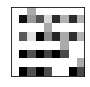

In [18]:
deg=1
mc,icv=SINDyCV_t(polypool_(Sol[:,:].T,deg),Soldt[:,:].T,0.01,1e-16,1e-16,0.0,10,ptf=1,normalise='auto',reticv=True)
names=polypool_names_(['x_1','x_2','x_3','x_4','x_5','x_6','x_7','x_8'],deg)
dispmymod(mc,['x_1\'','x_2\'','x_3\'','x_4\'','x_5\'','x_6\'','x_7\'','x_8\''],names)

plt.figure(figsize=(deg*1.5,1.5))
plt.imshow(np.log10(np.abs(mc.T)),cmap='gray_r',aspect='auto',vmin=-1,vmax=2)
plt.tight_layout()
plt.xticks([])
plt.yticks([])
plt.show()

#corr=np.nan_to_num(mc/mc)

C:\Users\rautj\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log10
  if __name__ == "__main__":


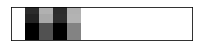

[[   0.      0.      0.      0.  ]
 [  30.     36.98  399.94  399.99]
 [   0.83    1.03   11.11   11.11]
 [  30.     28.36 2267.02 2267.03]
 [   0.83    0.79    2.85    2.85]
 [   0.      0.      0.      0.  ]
 [   0.      0.      0.      0.  ]
 [   0.      0.      0.      0.  ]
 [   0.      0.      0.      0.  ]
 [   0.      0.      0.      0.  ]
 [   0.      0.      0.      0.  ]
 [   0.      0.      0.      0.  ]
 [   0.      0.      0.      0.  ]]


C:\Users\rautj\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide


In [19]:
deg=3
ptfi=0.3
mc=np.hstack((SINDyCV_t(polypool_(dxc[:,:].T,deg),Soldt[1:2,:].T,0.01,1e-16,1e-16,0.0,10,ptf=ptfi)
              ,SINDyCV_t(polypool_(dthetac[:,:].T,deg),Soldt[3:4,:].T,0.01,1e-16,1e-16,0.0,10,ptf=ptfi)
              ,SINDyCV_t(polypool_(dxf[:,:].T,deg),Soldt[5:6,:].T,0.01,1e-16,1e-16,0.0,10,ptf=ptfi)
              ,SINDyCV_t(polypool_(dxr[:,:].T,deg),Soldt[7:8,:].T,0.01,1e-16,1e-16,0.0,10,ptf=ptfi)))

plt.figure(figsize=(deg*1,1))
plt.imshow(np.log10(np.abs(mc.T)),cmap='gray_r',aspect='auto',vmin=-1,vmax=2)
plt.tight_layout()
plt.xticks([])
plt.yticks([])
plt.show()

np.set_printoptions(suppress=True)
print(mc.round(2))
np.set_printoptions(suppress=False)
corr=np.nan_to_num(mc/mc)

In [20]:
#normalisation - noise free
nc=np.abs(Soldt.T).max(axis=0);nSoldt=Soldt.T/nc;nSoldt=nSoldt.T;nSoldtnf=np.copy(nSoldt)

ncdxc=np.abs(dxc.T).max(axis=0);ndxc=dxc.T/ncdxc;ndxc=ndxc.T;ndxcnf=np.copy(ndxc)
ncdthetac=np.abs(dthetac.T).max(axis=0);ndthetac=dthetac.T/ncdthetac;ndthetac=ndthetac.T;ndthetacnf=np.copy(ndthetac)
ncdxf=np.abs(dxf.T).max(axis=0);ndxf=dxf.T/ncdxf;ndxf=ndxf.T;ndxfnf=np.copy(ndxf)
ncdxr=np.abs(dxr.T).max(axis=0);ndxr=dxr.T/ncdxr;ndxr=ndxr.T;ndxrnf=np.copy(ndxr)

#noise addition
nlevel=0.03

for i in range(nSoldt.shape[0]):
    #nSoldt=np.random.normal(nSoldt,nlevel/2)
    nSoldt[i]=nSoldt[i]+nlevel/2*cn(0,len(nSoldt[i]))

for i in range(ndxc.shape[0]):
    #ndxc=np.random.normal(ndxc,nlevel/2)
    ndxc[i]=ndxc[i]+nlevel/2*cn(0,len(ndxc[i]))
for i in range(ndthetac.shape[0]):
    #ndthetac=np.random.normal(ndthetac,nlevel/2)
    ndthetac[i]=ndthetac[i]+nlevel/2*cn(0,len(ndthetac[i]))
for i in range(ndxf.shape[0]):
    #ndxf=np.random.normal(ndxf,nlevel/2)
    ndxf[i]=ndxf[i]+nlevel/2*cn(0,len(ndxf[i]))
for i in range(ndxr.shape[0]):
    #ndxr=np.random.normal(ndxr,nlevel/2)
    ndxr[i]=ndxr[i]+nlevel/2*cn(0,len(ndxr[i]))

#implied noisy measurements - unnormalised
uSoldt=(nSoldt.T*nc).T

udxc=(ndxc.T*ncdxc).T
udthetac=(ndthetac.T*ncdthetac).T
udxf=(ndxf.T*ncdxf).T
udxr=(ndxr.T*ncdxr).T

In [22]:
STSRATE=[]
optthress=[]

thress=np.linspace(0.01,0.75,10)
nlevels=np.linspace(0.0,0.04,11)

for a in tnrange(100):
    stsrate=[]
    optthres=np.nan*np.ones_like(nlevels)
    for inlevel in range(len(nlevels)):
        #normalisation - noise free
        nc=np.abs(Soldt.T).max(axis=0);nSoldt=Soldt.T/nc;nSoldt=nSoldt.T;nSoldtnf=np.copy(nSoldt)

        ncdxc=np.abs(dxc.T).max(axis=0);ndxc=dxc.T/ncdxc;ndxc=ndxc.T;ndxcnf=np.copy(ndxc)
        ncdthetac=np.abs(dthetac.T).max(axis=0);ndthetac=dthetac.T/ncdthetac;ndthetac=ndthetac.T;ndthetacnf=np.copy(ndthetac)
        ncdxf=np.abs(dxf.T).max(axis=0);ndxf=dxf.T/ncdxf;ndxf=ndxf.T;ndxfnf=np.copy(ndxf)
        ncdxr=np.abs(dxr.T).max(axis=0);ndxr=dxr.T/ncdxr;ndxr=ndxr.T;ndxrnf=np.copy(ndxr)

        #noise addition
        nlevel=nlevels[inlevel]

        for i in range(nSoldt.shape[0]):
            #nSoldt=np.random.normal(nSoldt,nlevel/2)
            nSoldt[i]=nSoldt[i]+nlevel/2*cn(0,len(nSoldt[i]))

        for i in range(ndxc.shape[0]):
            #ndxc=np.random.normal(ndxc,nlevel/2)
            ndxc[i]=ndxc[i]+nlevel/2*cn(0,len(ndxc[i]))
        for i in range(ndthetac.shape[0]):
            #ndthetac=np.random.normal(ndthetac,nlevel/2)
            ndthetac[i]=ndthetac[i]+nlevel/2*cn(0,len(ndthetac[i]))
        for i in range(ndxf.shape[0]):
            #ndxf=np.random.normal(ndxf,nlevel/2)
            ndxf[i]=ndxf[i]+nlevel/2*cn(0,len(ndxf[i]))
        for i in range(ndxr.shape[0]):
            #ndxr=np.random.normal(ndxr,nlevel/2)
            ndxr[i]=ndxr[i]+nlevel/2*cn(0,len(ndxr[i]))

        #implied noisy measurements - unnormalised
        uSoldt=(nSoldt.T*nc).T

        udxc=(ndxc.T*ncdxc).T
        udthetac=(ndthetac.T*ncdthetac).T
        udxf=(ndxf.T*ncdxf).T
        udxr=(ndxr.T*ncdxr).T

        success=False
        for ithres in range(len(thress)):
            if not success:
                mc=np.hstack((SINDy(polypool_(udxc[:,:].T,deg),uSoldt[1:2,:].T,thress[ithres],reg=1e-16,normalise='auto'),
                              SINDy(polypool_(udthetac[:,:].T,deg),uSoldt[3:4,:].T,thress[ithres],reg=1e-16,normalise='auto'),
                              SINDy(polypool_(udxf[:,:].T,deg),uSoldt[5:6,:].T,thress[ithres],reg=1e-16,normalise='auto'),
                              SINDy(polypool_(udxr[:,:].T,deg),uSoldt[7:8,:].T,thress[ithres],reg=1e-16,normalise='auto')))
                if np.all(np.nan_to_num(mc/mc)==corr):
                    success=True
                    optthres[inlevel]=thress[ithres]
        stsrate.append(success)
    optthress.append(optthres)
    
    STSRATE.append(stsrate)

C:\Users\rautj\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  import sys


  0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\rautj\Anaconda3\lib\site-packages\ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in true_divide


In [26]:
#never works
STSRATE=np.array([[False, False, False, False, False, False, False, False, False, False, False]])

In [27]:
ESRATE=[]

optthres=np.nan_to_num(np.nansum(optthress,axis=0)/np.nansum(np.abs(np.array(optthress)/np.array(optthress)),axis=0), nan=0.7)

for a in tnrange(100):
    esrate=[]
    for inlevel in range(len(nlevels)):
        #print(inlevel)
        #normalisation - noise free
        nc=np.abs(Soldt.T).max(axis=0);nSoldt=Soldt.T/nc;nSoldt=nSoldt.T;nSoldtnf=np.copy(nSoldt)

        ncdxc=np.abs(dxc.T).max(axis=0);ndxc=dxc.T/ncdxc;ndxc=ndxc.T;ndxcnf=np.copy(ndxc)
        ncdthetac=np.abs(dthetac.T).max(axis=0);ndthetac=dthetac.T/ncdthetac;ndthetac=ndthetac.T;ndthetacnf=np.copy(ndthetac)
        ncdxf=np.abs(dxf.T).max(axis=0);ndxf=dxf.T/ncdxf;ndxf=ndxf.T;ndxfnf=np.copy(ndxf)
        ncdxr=np.abs(dxr.T).max(axis=0);ndxr=dxr.T/ncdxr;ndxr=ndxr.T;ndxrnf=np.copy(ndxr)

        #noise addition
        nlevel=nlevels[inlevel]

        for i in range(nSoldt.shape[0]):
            #nSoldt=np.random.normal(nSoldt,nlevel/2)
            nSoldt[i]=nSoldt[i]+nlevel/2*cn(0,len(nSoldt[i]))

        for i in range(ndxc.shape[0]):
            #ndxc=np.random.normal(ndxc,nlevel/2)
            ndxc[i]=ndxc[i]+nlevel/2*cn(0,len(ndxc[i]))
        for i in range(ndthetac.shape[0]):
            #ndthetac=np.random.normal(ndthetac,nlevel/2)
            ndthetac[i]=ndthetac[i]+nlevel/2*cn(0,len(ndthetac[i]))
        for i in range(ndxf.shape[0]):
            #ndxf=np.random.normal(ndxf,nlevel/2)
            ndxf[i]=ndxf[i]+nlevel/2*cn(0,len(ndxf[i]))
        for i in range(ndxr.shape[0]):
            #ndxr=np.random.normal(ndxr,nlevel/2)
            ndxr[i]=ndxr[i]+nlevel/2*cn(0,len(ndxr[i]))

        #implied noisy measurements - unnormalised
        uSoldt=(nSoldt.T*nc).T

        udxc=(ndxc.T*ncdxc).T
        udthetac=(ndthetac.T*ncdthetac).T
        udxf=(ndxf.T*ncdxf).T
        udxr=(ndxr.T*ncdxr).T

        success=False
        for incp in np.arange(0.1,1,0.1):
            #print(incp)
            if not success:
                mc=np.hstack((ESINDy(polypool_(udxc[:,:].T,deg),uSoldt[1:2,:].T,optthres[inlevel],100,0.632,1e-16,incp),
                              ESINDy(polypool_(udthetac[:,:].T,deg),uSoldt[3:4,:].T,optthres[inlevel],100,0.632,1e-16,incp),
                              ESINDy(polypool_(udxf[:,:].T,deg),uSoldt[5:6,:].T,optthres[inlevel],100,0.632,1e-16,incp),
                              ESINDy(polypool_(udxr[:,:].T,deg),uSoldt[7:8,:].T,optthres[inlevel],100,0.632,1e-16,incp)))
                #print(mc)
                if np.all(np.nan_to_num(mc/mc)==corr):
                    success=True
        esrate.append(success)
    
    ESRATE.append(esrate)

C:\Users\rautj\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\rautj\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  """


  0%|          | 0/100 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [28]:
#only 0% works
ESRATE=np.array([[True, False, False, False, False, False, False, False, False, False, False]])

In [29]:
CVSRATE=[]

ptfs=np.geomspace(0.11,0.14,10)*1
ptfs=np.append([0.3],ptfs)

for a in tnrange(100):
    cvsrate=[]
    for inlevel in range(len(nlevels)):
        #normalisation - noise free
        nc=np.abs(Soldt.T).max(axis=0);nSoldt=Soldt.T/nc;nSoldt=nSoldt.T;nSoldtnf=np.copy(nSoldt)

        ncdxc=np.abs(dxc.T).max(axis=0);ndxc=dxc.T/ncdxc;ndxc=ndxc.T;ndxcnf=np.copy(ndxc)
        ncdthetac=np.abs(dthetac.T).max(axis=0);ndthetac=dthetac.T/ncdthetac;ndthetac=ndthetac.T;ndthetacnf=np.copy(ndthetac)
        ncdxf=np.abs(dxf.T).max(axis=0);ndxf=dxf.T/ncdxf;ndxf=ndxf.T;ndxfnf=np.copy(ndxf)
        ncdxr=np.abs(dxr.T).max(axis=0);ndxr=dxr.T/ncdxr;ndxr=ndxr.T;ndxrnf=np.copy(ndxr)

        #noise addition
        nlevel=nlevels[inlevel]

        for i in range(nSoldt.shape[0]):
            #nSoldt=np.random.normal(nSoldt,nlevel/2)
            nSoldt[i]=nSoldt[i]+nlevel/2*cn(0,len(nSoldt[i]))

        for i in range(ndxc.shape[0]):
            #ndxc=np.random.normal(ndxc,nlevel/2)
            ndxc[i]=ndxc[i]+nlevel/2*cn(0,len(ndxc[i]))
        for i in range(ndthetac.shape[0]):
            #ndthetac=np.random.normal(ndthetac,nlevel/2)
            ndthetac[i]=ndthetac[i]+nlevel/2*cn(0,len(ndthetac[i]))
        for i in range(ndxf.shape[0]):
            #ndxf=np.random.normal(ndxf,nlevel/2)
            ndxf[i]=ndxf[i]+nlevel/2*cn(0,len(ndxf[i]))
        for i in range(ndxr.shape[0]):
            #ndxr=np.random.normal(ndxr,nlevel/2)
            ndxr[i]=ndxr[i]+nlevel/2*cn(0,len(ndxr[i]))

        #implied noisy measurements - unnormalised
        uSoldt=(nSoldt.T*nc).T

        udxc=(ndxc.T*ncdxc).T
        udthetac=(ndthetac.T*ncdthetac).T
        udxf=(ndxf.T*ncdxf).T
        udxr=(ndxr.T*ncdxr).T

        success=False
        for iptf in range(len(ptfs)):
            ptfi=ptfs[iptf]
            if not success:
                mc=np.hstack((SINDyCV_t(polypool_(udxc[:,:].T,deg),uSoldt[1:2,:].T,0.01,1e-16,1e-16,0.0,10,ptf=ptfi),
                              SINDyCV_t(polypool_(udthetac[:,:].T,deg),uSoldt[3:4,:].T,0.01,1e-16,1e-16,0.0,10,ptf=ptfi),
                              SINDyCV_t(polypool_(udxf[:,:].T,deg),uSoldt[5:6,:].T,0.01,1e-16,1e-16,0.0,10,ptf=ptfi),
                              SINDyCV_t(polypool_(udxr[:,:].T,deg),uSoldt[7:8,:].T,0.01,1e-16,1e-16,0.0,10,ptf=ptfi)))
                if np.all(np.nan_to_num(mc/mc)==corr):
                    success=True
        cvsrate.append(success)
    
    CVSRATE.append(cvsrate)

C:\Users\rautj\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  


  0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\rautj\Anaconda3\lib\site-packages\ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in true_divide


In [30]:
CVSTSRATE=[]

for a in tnrange(100):
    cvstsrate=[]
    for inlevel in range(len(nlevels)):
        #normalisation - noise free
        nc=np.abs(Soldt.T).max(axis=0);nSoldt=Soldt.T/nc;nSoldt=nSoldt.T;nSoldtnf=np.copy(nSoldt)

        ncdxc=np.abs(dxc.T).max(axis=0);ndxc=dxc.T/ncdxc;ndxc=ndxc.T;ndxcnf=np.copy(ndxc)
        ncdthetac=np.abs(dthetac.T).max(axis=0);ndthetac=dthetac.T/ncdthetac;ndthetac=ndthetac.T;ndthetacnf=np.copy(ndthetac)
        ncdxf=np.abs(dxf.T).max(axis=0);ndxf=dxf.T/ncdxf;ndxf=ndxf.T;ndxfnf=np.copy(ndxf)
        ncdxr=np.abs(dxr.T).max(axis=0);ndxr=dxr.T/ncdxr;ndxr=ndxr.T;ndxrnf=np.copy(ndxr)

        #noise addition
        nlevel=nlevels[inlevel]

        for i in range(nSoldt.shape[0]):
            #nSoldt=np.random.normal(nSoldt,nlevel/2)
            nSoldt[i]=nSoldt[i]+nlevel/2*cn(0,len(nSoldt[i]))

        for i in range(ndxc.shape[0]):
            #ndxc=np.random.normal(ndxc,nlevel/2)
            ndxc[i]=ndxc[i]+nlevel/2*cn(0,len(ndxc[i]))
        for i in range(ndthetac.shape[0]):
            #ndthetac=np.random.normal(ndthetac,nlevel/2)
            ndthetac[i]=ndthetac[i]+nlevel/2*cn(0,len(ndthetac[i]))
        for i in range(ndxf.shape[0]):
            #ndxf=np.random.normal(ndxf,nlevel/2)
            ndxf[i]=ndxf[i]+nlevel/2*cn(0,len(ndxf[i]))
        for i in range(ndxr.shape[0]):
            #ndxr=np.random.normal(ndxr,nlevel/2)
            ndxr[i]=ndxr[i]+nlevel/2*cn(0,len(ndxr[i]))

        #implied noisy measurements - unnormalised
        uSoldt=(nSoldt.T*nc).T

        udxc=(ndxc.T*ncdxc).T
        udthetac=(ndthetac.T*ncdthetac).T
        udxf=(ndxf.T*ncdxf).T
        udxr=(ndxr.T*ncdxr).T

        success=False
        pen=1e-16
        for iptf in range(len(ptfs)):
            ptfi=ptfs[iptf]
            if not success:
                mc0=np.hstack((SINDyCV_t(polypool_(udxc[:,:].T,deg),uSoldt[1:2,:].T,0.01,pen,pen,0.0,10,ptf=ptfi),
                               SINDyCV_t(polypool_(udthetac[:,:].T,deg),uSoldt[3:4,:].T,0.01,pen,pen,0.0,10,ptf=ptfi),
                               SINDyCV_t(polypool_(udxf[:,:].T,deg),uSoldt[5:6,:].T,0.01,pen,pen,0.0,10,ptf=ptfi),
                               SINDyCV_t(polypool_(udxr[:,:].T,deg),uSoldt[7:8,:].T,0.01,pen,pen,0.0,10,ptf=ptfi)))
                for ithres in range(len(thress)):
                    mc=np.hstack((re_SINDy(polypool_(udxc[:,:].T,deg),uSoldt[1:2,:].T,copy.deepcopy(mc0[:,0:1]),thress[ithres],reg=1e-16,normalise='auto'),
                                  re_SINDy(polypool_(udthetac[:,:].T,deg),uSoldt[3:4,:].T,copy.deepcopy(mc0[:,1:2]),thress[ithres],reg=1e-16,normalise='auto'),
                                  re_SINDy(polypool_(udxf[:,:].T,deg),uSoldt[5:6,:].T,copy.deepcopy(mc0[:,2:3]),thress[ithres],reg=1e-16,normalise='auto'),
                                  re_SINDy(polypool_(udxr[:,:].T,deg),uSoldt[7:8,:].T,copy.deepcopy(mc0[:,3:4]),thress[ithres],reg=1e-16,normalise='auto')))
                    if np.all(np.nan_to_num(mc/mc)==corr):
                        success=True
        cvstsrate.append(success)
    
    CVSTSRATE.append(cvstsrate)

C:\Users\rautj\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  This is separate from the ipykernel package so we can avoid doing imports until


  0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\rautj\Anaconda3\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in true_divide


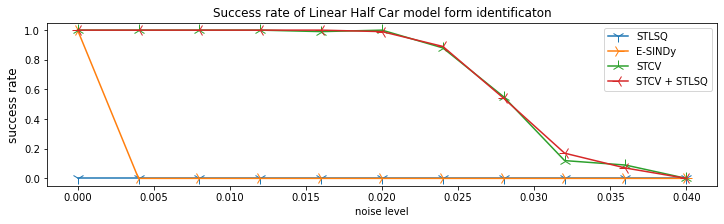

In [31]:
plt.figure(figsize=(12,3))
plt.title('Success rate of Linear Half Car model form identificaton')
plt.ylabel('success rate',fontsize=12)
plt.xlabel('noise level')
plt.plot(nlevels,np.average(np.array(STSRATE),axis=0),'1-',markersize=12,label='STLSQ')
plt.plot(nlevels,np.average(np.array(ESRATE),axis=0),'4-',markersize=12,label='E-SINDy')
plt.plot(nlevels,np.average(np.array(CVSRATE),axis=0),'2-',markersize=12,label='STCV')
plt.plot(nlevels,np.average(np.array(CVSTSRATE),axis=0),'3-',markersize=12,label='STCV + STLSQ')
plt.legend()
plt.show()

In [32]:
np.vstack((np.average(np.array(STSRATE),axis=0),np.average(np.array(ESRATE),axis=0),np.average(np.array(CVSRATE),axis=0),np.average(np.array(CVSTSRATE),axis=0)))

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [1.  , 1.  , 1.  , 1.  , 0.99, 1.  , 0.88, 0.55, 0.12, 0.09, 0.  ],
       [1.  , 1.  , 1.  , 1.  , 1.  , 0.99, 0.89, 0.54, 0.17, 0.07, 0.  ]])

In [33]:
#np.savetxt('linearcar.stcv',np.vstack((np.average(np.array(STSRATE),axis=0),np.average(np.array(ESRATE),axis=0),np.average(np.array(CVSRATE),axis=0),np.average(np.array(CVSTSRATE),axis=0))))

In [35]:
np.loadtxt('linearcar.stcv')

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [1.  , 1.  , 1.  , 1.  , 0.99, 1.  , 0.88, 0.55, 0.12, 0.09, 0.  ],
       [1.  , 1.  , 1.  , 1.  , 1.  , 0.99, 0.89, 0.54, 0.17, 0.07, 0.  ]])

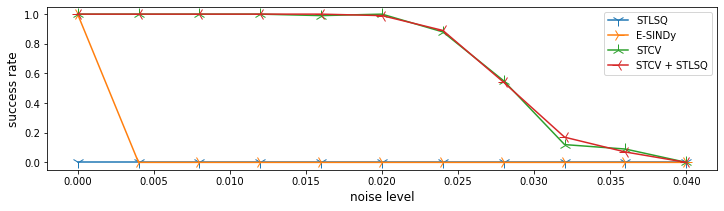

In [36]:
plt.figure(figsize=(12,3))
plt.ylabel('success rate',fontsize=12)
plt.xlabel('noise level',fontsize=12)
plt.plot(nlevels,np.loadtxt('linearcar.stcv')[0],'1-',markersize=12,label='STLSQ')
plt.plot(nlevels,np.loadtxt('linearcar.stcv')[1],'4-',markersize=12,label='E-SINDy')
plt.plot(nlevels,np.loadtxt('linearcar.stcv')[2],'2-',markersize=12,label='STCV')
plt.plot(nlevels,np.loadtxt('linearcar.stcv')[3],'3-',markersize=12,label='STCV + STLSQ')
#plt.xticks(nlevels[::2],['']*6)
plt.legend()
plt.show()

In [37]:
#Linear Car - normalised

In [38]:
#normalisation - noise free
nc=np.abs(Soldt.T).max(axis=0);nSoldt=Soldt.T/nc;nSoldt=nSoldt.T;nSoldtnf=np.copy(nSoldt)

ncdxc=np.abs(dxc.T).max(axis=0);ndxc=dxc.T/ncdxc;ndxc=ndxc.T;ndxcnf=np.copy(ndxc)
ncdthetac=np.abs(dthetac.T).max(axis=0);ndthetac=dthetac.T/ncdthetac;ndthetac=ndthetac.T;ndthetacnf=np.copy(ndthetac)
ncdxf=np.abs(dxf.T).max(axis=0);ndxf=dxf.T/ncdxf;ndxf=ndxf.T;ndxfnf=np.copy(ndxf)
ncdxr=np.abs(dxr.T).max(axis=0);ndxr=dxr.T/ncdxr;ndxr=ndxr.T;ndxrnf=np.copy(ndxr)

#noise addition
nlevel=0.03

for i in range(nSoldt.shape[0]):
    #nSoldt=np.random.normal(nSoldt,nlevel/2)
    nSoldt[i]=nSoldt[i]+nlevel/2*cn(0,len(nSoldt[i]))

for i in range(ndxc.shape[0]):
    #ndxc=np.random.normal(ndxc,nlevel/2)
    ndxc[i]=ndxc[i]+nlevel/2*cn(0,len(ndxc[i]))
for i in range(ndthetac.shape[0]):
    #ndthetac=np.random.normal(ndthetac,nlevel/2)
    ndthetac[i]=ndthetac[i]+nlevel/2*cn(0,len(ndthetac[i]))
for i in range(ndxf.shape[0]):
    #ndxf=np.random.normal(ndxf,nlevel/2)
    ndxf[i]=ndxf[i]+nlevel/2*cn(0,len(ndxf[i]))
for i in range(ndxr.shape[0]):
    #ndxr=np.random.normal(ndxr,nlevel/2)
    ndxr[i]=ndxr[i]+nlevel/2*cn(0,len(ndxr[i]))

#implied noisy measurements - unnormalised
uSoldt=(nSoldt.T*nc).T

udxc=(ndxc.T*ncdxc).T
udthetac=(ndthetac.T*ncdthetac).T
udxf=(ndxf.T*ncdxf).T
udxr=(ndxr.T*ncdxr).T

C:\Users\rautj\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log10
  if __name__ == "__main__":


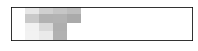

[[0.   0.   0.   0.  ]
 [0.2  0.43 0.15 0.14]
 [0.36 0.81 0.27 0.18]
 [0.47 0.8  0.87 0.83]
 [0.59 0.99 0.07 0.04]
 [0.   0.   0.   0.  ]
 [0.   0.   0.   0.  ]
 [0.   0.   0.   0.  ]
 [0.   0.   0.   0.  ]
 [0.   0.   0.   0.  ]
 [0.   0.   0.   0.  ]
 [0.   0.   0.   0.  ]
 [0.   0.   0.   0.  ]]


C:\Users\rautj\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide


In [39]:
deg=3
ptfi=0.5
mc=np.hstack((SINDyCV_t(polypool_(ndxcnf[:,:].T,deg),nSoldtnf[1:2,:].T,0.01,1e-16,1e-16,0.0,10,ptf=ptfi)
              ,SINDyCV_t(polypool_(ndthetacnf[:,:].T,deg),nSoldtnf[3:4,:].T,0.01,1e-16,1e-16,0.0,10,ptf=ptfi)
              ,SINDyCV_t(polypool_(ndxfnf[:,:].T,deg),nSoldtnf[5:6,:].T,0.01,1e-16,1e-16,0.0,10,ptf=ptfi)
              ,SINDyCV_t(polypool_(ndxrnf[:,:].T,deg),nSoldtnf[7:8,:].T,0.01,1e-16,1e-16,0.0,10,ptf=1)))

plt.figure(figsize=(deg*1,1))
plt.imshow(np.log10(np.abs(mc.T)),cmap='gray_r',aspect='auto',vmin=-1,vmax=2)
plt.tight_layout()
plt.xticks([])
plt.yticks([])
plt.show()

np.set_printoptions(suppress=True)
print(mc.round(2))
np.set_printoptions(suppress=False)
corr=np.nan_to_num(mc/mc)

In [40]:
STSRATE=[]
optthress=[]

thress=np.linspace(0.01,0.04,10)
nlevels=np.linspace(0.0,0.04,11)

for a in tnrange(100):
    stsrate=[]
    optthres=np.nan*np.ones_like(nlevels)
    for inlevel in range(len(nlevels)):
        #normalisation - noise free
        nc=np.abs(Soldt.T).max(axis=0);nSoldt=Soldt.T/nc;nSoldt=nSoldt.T;nSoldtnf=np.copy(nSoldt)

        ncdxc=np.abs(dxc.T).max(axis=0);ndxc=dxc.T/ncdxc;ndxc=ndxc.T;ndxcnf=np.copy(ndxc)
        ncdthetac=np.abs(dthetac.T).max(axis=0);ndthetac=dthetac.T/ncdthetac;ndthetac=ndthetac.T;ndthetacnf=np.copy(ndthetac)
        ncdxf=np.abs(dxf.T).max(axis=0);ndxf=dxf.T/ncdxf;ndxf=ndxf.T;ndxfnf=np.copy(ndxf)
        ncdxr=np.abs(dxr.T).max(axis=0);ndxr=dxr.T/ncdxr;ndxr=ndxr.T;ndxrnf=np.copy(ndxr)

        #noise addition
        nlevel=nlevels[inlevel]

        for i in range(nSoldt.shape[0]):
            #nSoldt=np.random.normal(nSoldt,nlevel/2)
            nSoldt[i]=nSoldt[i]+nlevel/2*cn(0,len(nSoldt[i]))

        for i in range(ndxc.shape[0]):
            #ndxc=np.random.normal(ndxc,nlevel/2)
            ndxc[i]=ndxc[i]+nlevel/2*cn(0,len(ndxc[i]))
        for i in range(ndthetac.shape[0]):
            #ndthetac=np.random.normal(ndthetac,nlevel/2)
            ndthetac[i]=ndthetac[i]+nlevel/2*cn(0,len(ndthetac[i]))
        for i in range(ndxf.shape[0]):
            #ndxf=np.random.normal(ndxf,nlevel/2)
            ndxf[i]=ndxf[i]+nlevel/2*cn(0,len(ndxf[i]))
        for i in range(ndxr.shape[0]):
            #ndxr=np.random.normal(ndxr,nlevel/2)
            ndxr[i]=ndxr[i]+nlevel/2*cn(0,len(ndxr[i]))

        #implied noisy measurements - unnormalised
        uSoldt=(nSoldt.T*nc).T

        udxc=(ndxc.T*ncdxc).T
        udthetac=(ndthetac.T*ncdthetac).T
        udxf=(ndxf.T*ncdxf).T
        udxr=(ndxr.T*ncdxr).T

        success=False
        for ithres in range(len(thress)):
            if not success:
                mc=np.hstack((SINDy(polypool_(ndxc[:,:].T,deg),nSoldt[1:2,:].T,thress[ithres],reg=1e-16,normalise='auto'),
                              SINDy(polypool_(ndthetac[:,:].T,deg),nSoldt[3:4,:].T,thress[ithres],reg=1e-16,normalise='auto'),
                              SINDy(polypool_(ndxf[:,:].T,deg),nSoldt[5:6,:].T,thress[ithres],reg=1e-16,normalise='auto'),
                              SINDy(polypool_(ndxr[:,:].T,deg),nSoldt[7:8,:].T,thress[ithres],reg=1e-16,normalise='auto')))
                if np.all(np.nan_to_num(mc/mc)==corr):
                    success=True
                    optthres[inlevel]=thress[ithres]
        stsrate.append(success)
    optthress.append(optthres)
    
    STSRATE.append(stsrate)

C:\Users\rautj\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  import sys


  0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\rautj\Anaconda3\lib\site-packages\ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in true_divide


In [ ]:
ESRATE=[]

optthres=np.nan_to_num(np.nansum(optthress,axis=0)/np.nansum(np.abs(np.array(optthress)/np.array(optthress)),axis=0), nan=0.038)

for a in tnrange(100):
    esrate=[]
    for inlevel in range(len(nlevels)):
        #print(inlevel)
        #normalisation - noise free
        nc=np.abs(Soldt.T).max(axis=0);nSoldt=Soldt.T/nc;nSoldt=nSoldt.T;nSoldtnf=np.copy(nSoldt)

        ncdxc=np.abs(dxc.T).max(axis=0);ndxc=dxc.T/ncdxc;ndxc=ndxc.T;ndxcnf=np.copy(ndxc)
        ncdthetac=np.abs(dthetac.T).max(axis=0);ndthetac=dthetac.T/ncdthetac;ndthetac=ndthetac.T;ndthetacnf=np.copy(ndthetac)
        ncdxf=np.abs(dxf.T).max(axis=0);ndxf=dxf.T/ncdxf;ndxf=ndxf.T;ndxfnf=np.copy(ndxf)
        ncdxr=np.abs(dxr.T).max(axis=0);ndxr=dxr.T/ncdxr;ndxr=ndxr.T;ndxrnf=np.copy(ndxr)

        #noise addition
        nlevel=nlevels[inlevel]

        for i in range(nSoldt.shape[0]):
            #nSoldt=np.random.normal(nSoldt,nlevel/2)
            nSoldt[i]=nSoldt[i]+nlevel/2*cn(0,len(nSoldt[i]))

        for i in range(ndxc.shape[0]):
            #ndxc=np.random.normal(ndxc,nlevel/2)
            ndxc[i]=ndxc[i]+nlevel/2*cn(0,len(ndxc[i]))
        for i in range(ndthetac.shape[0]):
            #ndthetac=np.random.normal(ndthetac,nlevel/2)
            ndthetac[i]=ndthetac[i]+nlevel/2*cn(0,len(ndthetac[i]))
        for i in range(ndxf.shape[0]):
            #ndxf=np.random.normal(ndxf,nlevel/2)
            ndxf[i]=ndxf[i]+nlevel/2*cn(0,len(ndxf[i]))
        for i in range(ndxr.shape[0]):
            #ndxr=np.random.normal(ndxr,nlevel/2)
            ndxr[i]=ndxr[i]+nlevel/2*cn(0,len(ndxr[i]))

        #implied noisy measurements - unnormalised
        uSoldt=(nSoldt.T*nc).T

        udxc=(ndxc.T*ncdxc).T
        udthetac=(ndthetac.T*ncdthetac).T
        udxf=(ndxf.T*ncdxf).T
        udxr=(ndxr.T*ncdxr).T

        success=False
        for incp in np.arange(0.1,1,0.1):
            #print(incp)
            if not success:
                mc=np.hstack((ESINDy(polypool_(ndxc[:,:].T,deg),nSoldt[1:2,:].T,optthres[inlevel],100,0.632,1e-16,incp),
                              ESINDy(polypool_(ndthetac[:,:].T,deg),nSoldt[3:4,:].T,optthres[inlevel],100,0.632,1e-16,incp),
                              ESINDy(polypool_(ndxf[:,:].T,deg),nSoldt[5:6,:].T,optthres[inlevel],100,0.632,1e-16,incp),
                              ESINDy(polypool_(ndxr[:,:].T,deg),nSoldt[7:8,:].T,optthres[inlevel],100,0.632,1e-16,incp)))
                #print(mc)
                if np.all(np.nan_to_num(mc/mc)==corr):
                    success=True
        esrate.append(success)
    
    ESRATE.append(esrate)

In [41]:
#Takes forever, this is an old instance:
ESRATE=np.array([[1, 1, 1, 0.95, 0.61, False, False, False, False, False, False]])

In [42]:
CVSRATE=[]

ptfs=np.geomspace(0.11,0.14,10)
#ptfs[0]=0.2

for a in tnrange(100):
    cvsrate=[]
    for inlevel in range(len(nlevels)):
        #normalisation - noise free
        nc=np.abs(Soldt.T).max(axis=0);nSoldt=Soldt.T/nc;nSoldt=nSoldt.T;nSoldtnf=np.copy(nSoldt)

        ncdxc=np.abs(dxc.T).max(axis=0);ndxc=dxc.T/ncdxc;ndxc=ndxc.T;ndxcnf=np.copy(ndxc)
        ncdthetac=np.abs(dthetac.T).max(axis=0);ndthetac=dthetac.T/ncdthetac;ndthetac=ndthetac.T;ndthetacnf=np.copy(ndthetac)
        ncdxf=np.abs(dxf.T).max(axis=0);ndxf=dxf.T/ncdxf;ndxf=ndxf.T;ndxfnf=np.copy(ndxf)
        ncdxr=np.abs(dxr.T).max(axis=0);ndxr=dxr.T/ncdxr;ndxr=ndxr.T;ndxrnf=np.copy(ndxr)

        #noise addition
        nlevel=nlevels[inlevel]

        for i in range(nSoldt.shape[0]):
            #nSoldt=np.random.normal(nSoldt,nlevel/2)
            nSoldt[i]=nSoldt[i]+nlevel/2*cn(0,len(nSoldt[i]))

        for i in range(ndxc.shape[0]):
            #ndxc=np.random.normal(ndxc,nlevel/2)
            ndxc[i]=ndxc[i]+nlevel/2*cn(0,len(ndxc[i]))
        for i in range(ndthetac.shape[0]):
            #ndthetac=np.random.normal(ndthetac,nlevel/2)
            ndthetac[i]=ndthetac[i]+nlevel/2*cn(0,len(ndthetac[i]))
        for i in range(ndxf.shape[0]):
            #ndxf=np.random.normal(ndxf,nlevel/2)
            ndxf[i]=ndxf[i]+nlevel/2*cn(0,len(ndxf[i]))
        for i in range(ndxr.shape[0]):
            #ndxr=np.random.normal(ndxr,nlevel/2)
            ndxr[i]=ndxr[i]+nlevel/2*cn(0,len(ndxr[i]))

        #implied noisy measurements - unnormalised
        uSoldt=(nSoldt.T*nc).T

        udxc=(ndxc.T*ncdxc).T
        udthetac=(ndthetac.T*ncdthetac).T
        udxf=(ndxf.T*ncdxf).T
        udxr=(ndxr.T*ncdxr).T

        success=False
        for iptf in range(len(ptfs)):
            ptfi=ptfs[iptf]
            if not success:
                mc=np.hstack((SINDyCV_t(polypool_(ndxc[:,:].T,deg),nSoldt[1:2,:].T,0.01,1e-16,1e-16,0.0,10,ptf=ptfi),
                              SINDyCV_t(polypool_(ndthetac[:,:].T,deg),nSoldt[3:4,:].T,0.01,1e-16,1e-16,0.0,10,ptf=ptfi),
                              SINDyCV_t(polypool_(ndxf[:,:].T,deg),nSoldt[5:6,:].T,0.01,1e-16,1e-16,0.0,10,ptf=ptfi),
                              SINDyCV_t(polypool_(ndxr[:,:].T,deg),nSoldt[7:8,:].T,0.01,1e-16,1e-16,0.0,10,ptf=ptfi)))
                if np.all(np.nan_to_num(mc/mc)==corr):
                    success=True
        cvsrate.append(success)
    
    CVSRATE.append(cvsrate)

C:\Users\rautj\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  


  0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\rautj\Anaconda3\lib\site-packages\ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in true_divide


In [43]:
CVSTSRATE=[]

for a in tnrange(100):
    cvstsrate=[]
    for inlevel in range(len(nlevels)):
        #normalisation - noise free
        nc=np.abs(Soldt.T).max(axis=0);nSoldt=Soldt.T/nc;nSoldt=nSoldt.T;nSoldtnf=np.copy(nSoldt)

        ncdxc=np.abs(dxc.T).max(axis=0);ndxc=dxc.T/ncdxc;ndxc=ndxc.T;ndxcnf=np.copy(ndxc)
        ncdthetac=np.abs(dthetac.T).max(axis=0);ndthetac=dthetac.T/ncdthetac;ndthetac=ndthetac.T;ndthetacnf=np.copy(ndthetac)
        ncdxf=np.abs(dxf.T).max(axis=0);ndxf=dxf.T/ncdxf;ndxf=ndxf.T;ndxfnf=np.copy(ndxf)
        ncdxr=np.abs(dxr.T).max(axis=0);ndxr=dxr.T/ncdxr;ndxr=ndxr.T;ndxrnf=np.copy(ndxr)

        #noise addition
        nlevel=nlevels[inlevel]

        for i in range(nSoldt.shape[0]):
            #nSoldt=np.random.normal(nSoldt,nlevel/2)
            nSoldt[i]=nSoldt[i]+nlevel/2*cn(0,len(nSoldt[i]))

        for i in range(ndxc.shape[0]):
            #ndxc=np.random.normal(ndxc,nlevel/2)
            ndxc[i]=ndxc[i]+nlevel/2*cn(0,len(ndxc[i]))
        for i in range(ndthetac.shape[0]):
            #ndthetac=np.random.normal(ndthetac,nlevel/2)
            ndthetac[i]=ndthetac[i]+nlevel/2*cn(0,len(ndthetac[i]))
        for i in range(ndxf.shape[0]):
            #ndxf=np.random.normal(ndxf,nlevel/2)
            ndxf[i]=ndxf[i]+nlevel/2*cn(0,len(ndxf[i]))
        for i in range(ndxr.shape[0]):
            #ndxr=np.random.normal(ndxr,nlevel/2)
            ndxr[i]=ndxr[i]+nlevel/2*cn(0,len(ndxr[i]))

        #implied noisy measurements - unnormalised
        uSoldt=(nSoldt.T*nc).T

        udxc=(ndxc.T*ncdxc).T
        udthetac=(ndthetac.T*ncdthetac).T
        udxf=(ndxf.T*ncdxf).T
        udxr=(ndxr.T*ncdxr).T

        success=False
        pen=1e-16
        for iptf in range(len(ptfs)):
            ptfi=ptfs[iptf]
            if not success:
                mc0=np.hstack((SINDyCV_t(polypool_(ndxc[:,:].T,deg),nSoldt[1:2,:].T,0.01,pen,pen,0.0,10,ptf=ptfi),
                               SINDyCV_t(polypool_(ndthetac[:,:].T,deg),nSoldt[3:4,:].T,0.01,pen,pen,0.0,10,ptf=ptfi),
                               SINDyCV_t(polypool_(ndxf[:,:].T,deg),nSoldt[5:6,:].T,0.01,pen,pen,0.0,10,ptf=ptfi),
                               SINDyCV_t(polypool_(ndxr[:,:].T,deg),nSoldt[7:8,:].T,0.01,pen,pen,0.0,10,ptf=ptfi)))
                for ithres in range(len(thress)):
                    mc=np.hstack((re_SINDy(polypool_(ndxc[:,:].T,deg),nSoldt[1:2,:].T,copy.deepcopy(mc0[:,0:1]),thress[ithres],reg=1e-16,normalise='auto'),
                                  re_SINDy(polypool_(ndthetac[:,:].T,deg),nSoldt[3:4,:].T,copy.deepcopy(mc0[:,1:2]),thress[ithres],reg=1e-16,normalise='auto'),
                                  re_SINDy(polypool_(ndxf[:,:].T,deg),nSoldt[5:6,:].T,copy.deepcopy(mc0[:,2:3]),thress[ithres],reg=1e-16,normalise='auto'),
                                  re_SINDy(polypool_(ndxr[:,:].T,deg),nSoldt[7:8,:].T,copy.deepcopy(mc0[:,3:4]),thress[ithres],reg=1e-16,normalise='auto')))
                    if np.all(np.nan_to_num(mc/mc)==corr):
                        success=True
        cvstsrate.append(success)
    
    CVSTSRATE.append(cvstsrate)

C:\Users\rautj\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  This is separate from the ipykernel package so we can avoid doing imports until


  0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\rautj\Anaconda3\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in true_divide


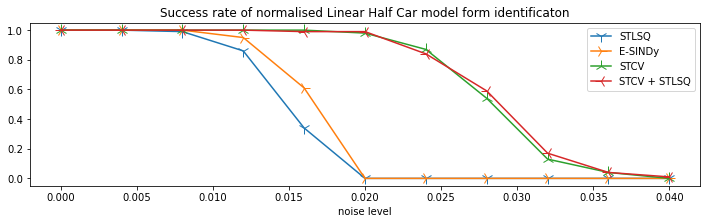

In [44]:
plt.figure(figsize=(12,3))
plt.title('Success rate of normalised Linear Half Car model form identificaton')
plt.xlabel('noise level')
plt.plot(nlevels,np.average(np.array(STSRATE),axis=0),'1-',markersize=12,label='STLSQ')
plt.plot(nlevels,np.average(np.array(ESRATE),axis=0),'4-',markersize=12,label='E-SINDy')
plt.plot(nlevels,np.average(np.array(CVSRATE),axis=0),'2-',markersize=12,label='STCV')
plt.plot(nlevels,np.average(np.array(CVSTSRATE),axis=0),'3-',markersize=12,label='STCV + STLSQ')
plt.legend()
plt.show()

In [45]:
np.vstack((np.average(np.array(STSRATE),axis=0),np.average(np.array(ESRATE),axis=0),np.average(np.array(CVSRATE),axis=0),np.average(np.array(CVSTSRATE),axis=0)))

array([[1.  , 1.  , 0.99, 0.86, 0.34, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [1.  , 1.  , 1.  , 0.95, 0.61, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [1.  , 1.  , 1.  , 1.  , 1.  , 0.98, 0.87, 0.54, 0.13, 0.04, 0.  ],
       [1.  , 1.  , 1.  , 1.  , 0.99, 0.99, 0.84, 0.59, 0.17, 0.04, 0.01]])

In [46]:
#np.savetxt('linearcarnorm.stcv',np.vstack((np.average(np.array(STSRATE),axis=0),np.average(np.array(ESRATE),axis=0),np.average(np.array(CVSRATE),axis=0),np.average(np.array(CVSTSRATE),axis=0))))

In [47]:
np.loadtxt('linearcarnorm.stcv')

array([[1.  , 1.  , 0.99, 0.86, 0.34, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [1.  , 1.  , 1.  , 0.95, 0.61, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [1.  , 1.  , 1.  , 1.  , 1.  , 0.98, 0.87, 0.54, 0.13, 0.04, 0.  ],
       [1.  , 1.  , 1.  , 1.  , 0.99, 0.99, 0.84, 0.59, 0.17, 0.04, 0.01]])

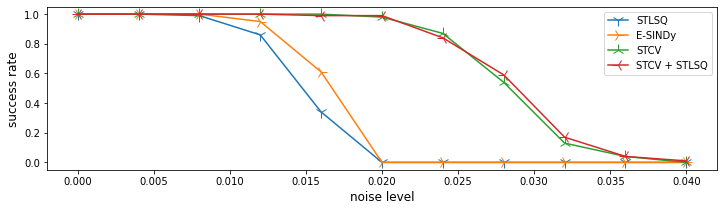

In [48]:
plt.figure(figsize=(12,3))
plt.ylabel('success rate',fontsize=12)
plt.xlabel('noise level',fontsize=12)
plt.plot(nlevels,np.loadtxt('linearcarnorm.stcv')[0],'1-',markersize=12,label='STLSQ')
plt.plot(nlevels,np.loadtxt('linearcarnorm.stcv')[1],'4-',markersize=12,label='E-SINDy')
plt.plot(nlevels,np.loadtxt('linearcarnorm.stcv')[2],'2-',markersize=12,label='STCV')
plt.plot(nlevels,np.loadtxt('linearcarnorm.stcv')[3],'3-',markersize=12,label='STCV + STLSQ')
#plt.xticks(nlevels[::2],['']*6)
plt.legend()
plt.show()

In [49]:
#non-linear car

In [50]:
def nlhcm(tlim,dt=0.01,bf=10,P=tuple([1794,3443,87,140,1.271,1.713,[20872,21622,61500],[592,418],[3268,11033,13542],[704,225],[101115],[0]])):
    
    """
    """
    
    def F(t):
        f=np.zeros(8).reshape(-1,1)
        if t%bf<0.0105:
            f[5,0]=0.5
        if (t-0.1)%bf<0.0105:
            f[7,0]=0.5
        return f
    
    def sys(t,x,ms,js,mf,mr,l1,l2,kf,cf,kr,cr,kt,ct):
        def nlkf(delta):
            force=0
            pow=1
            for ki in kf:
                force+=ki*(delta**pow)
                pow+=1
            return force
        def nlcf(delta):
            force=0
            pow=1
            for ci in cf:
                force+=ci*(delta**pow)
                pow+=1
            return force
        def nlkr(delta):
            force=0
            pow=1
            for ki in kr:
                force+=ki*(delta**pow)
                pow+=1
            return force
        def nlcr(delta):
            force=0
            pow=1
            for ci in cr:
                force+=ci*(delta**pow)
                pow+=1
            return force
        def nlkt(delta):
            force=0
            pow=1
            for ki in kt:
                force+=ki*(delta**pow)
                pow+=1
            return force
        def nlct(delta):
            force=0
            pow=1
            for ci in ct:
                force+=ci*(delta**pow)
            return force
        
        A=np.array([[x[1]]
                   ,[nlkf(-x[0]+x[4]-x[2]*l1)+nlcf(-x[1]+x[5]-x[3]*l1)+nlkr(-x[0]+x[6]+x[2]*l2)+nlcr(-x[1]+x[7]+x[3]*l2)]
                   ,[x[3]]
                   ,[l1*(nlkf(-x[0]+x[4]-x[2]*l1)+nlcf(-x[1]+x[5]-x[3]*l1))+l2*(nlkr(x[0]-x[6]-x[2]*l2)+nlcr(x[1]-x[7]-x[3]*l2))]
                   ,[x[5]]
                   ,[nlkf(x[0]-x[4]+x[2]*l1)+nlcf(x[1]-x[5]+x[3]*l1)+nlkt(-x[4])+nlct(-x[5])]
                   ,[x[7]]
                   ,[nlkr(x[0]-x[6]-x[2]*l2)+nlcr(x[1]-x[7]-x[3]*l2)+nlkt(-x[6])+nlct(-x[7])]])
        M=np.array([[1]
                   ,[ms]
                   ,[1]
                   ,[js]
                   ,[1]
                   ,[mf]
                   ,[1]
                   ,[mr]])
        B=np.array([[0]
                   ,[0]
                   ,[0]
                   ,[0]
                   ,[0]
                   ,[nlkt(F(t)[5])]
                   ,[0]
                   ,[nlkt(F(t)[7])]])
        
        dx=(A+B)/M
        return dx.reshape(1,-1).tolist()[0]

    tstamps=np.arange(0,tlim,dt)
    x0=[0,0,0,0,0,0,0,0]
    #x0=np.random.normal(size=8)*0.1
    
    #sol=sc.integrate.odeint(sys,x0,tstamps,args=P,rtol=1e-12,atol=1e-12);Sol=sol.T
    sol=sc.integrate.solve_ivp(sys,[0,tlim],x0,t_eval=tstamps,args=P,method='Radau',max_step=1e-3,rtol=1e-12,atol=1e-12).y;Sol=sol
    
    FF=[]
    for t in tstamps:
        FF.append(F(t))
    
    return tstamps, Sol, (dt,bf,P,FF)

In [51]:
tstamps,Sol,_=nlhcm(tlim=2.12,dt=2e-4,P=tuple([1794,3443,87,140,1.271,1.713,[20872,21622,61500],[592,418],[3268,11033,13542],[704,225],[101115],[0]]))
#tstamps,Sol,_=nlhcm(tlim=2.12,dt=2e-4,P=tuple([1794,3443,87,140,1.271,1.713,[20872,21622,61500],[1190],[3268,11033,13542],[1000],[101115],[0]]))
#tstamps,Sol,_=lhcm(tlim=2.12,dt=2e-4)
a,b=1.271,1.713
dt=_[0]
sf=1/dt
Sol=Sol[:,int(0.12/dt):]
tstamps=tstamps[int(0.12/dt):]
Soldt=np.gradient(Sol.T[:,:],dt,axis=0).T

#deflection signals
dxc=np.vstack((-Sol[0]+Sol[4]-Sol[2]*a,-Sol[1]+Sol[5]-Sol[3]*a,-Sol[0]+Sol[6]+Sol[2]*b,-Sol[1]+Sol[7]+Sol[3]*b))
dthetac=np.vstack((-Sol[0]+Sol[4]-Sol[2]*a,-Sol[1]+Sol[5]-Sol[3]*a,Sol[0]-Sol[6]-Sol[2]*b,Sol[1]-Sol[7]-Sol[3]*b))
dxf=np.vstack((Sol[0]-Sol[4]+Sol[2]*a,Sol[1]-Sol[5]+Sol[3]*a,-Sol[4],-Sol[5]))
dxr=np.vstack((Sol[0]-Sol[6]-Sol[2]*b,Sol[1]-Sol[7]-Sol[3]*b,-Sol[6],-Sol[7]))

#normalisation - noise free
nc=np.abs(Soldt.T).max(axis=0);nSoldt=Soldt.T/nc;nSoldt=nSoldt.T;nSoldtnf=np.copy(nSoldt)

ncdxc=np.abs(dxc.T).max(axis=0);ndxc=dxc.T/ncdxc;ndxc=ndxc.T;ndxcnf=np.copy(ndxc)
ncdthetac=np.abs(dthetac.T).max(axis=0);ndthetac=dthetac.T/ncdthetac;ndthetac=ndthetac.T;ndthetacnf=np.copy(ndthetac)
ncdxf=np.abs(dxf.T).max(axis=0);ndxf=dxf.T/ncdxf;ndxf=ndxf.T;ndxfnf=np.copy(ndxf)
ncdxr=np.abs(dxr.T).max(axis=0);ndxr=dxr.T/ncdxr;ndxr=ndxr.T;ndxrnf=np.copy(ndxr)

#noise addition
nlevel=0.001

for i in range(nSoldt.shape[0]):
    #nSoldt=np.random.normal(nSoldt,nlevel/2)
    nSoldt[i]=nSoldt[i]+nlevel/2*cn(0,len(nSoldt[i]))

for i in range(ndxc.shape[0]):
    #ndxc=np.random.normal(ndxc,nlevel/2)
    ndxc[i]=ndxc[i]+nlevel/2*cn(0,len(ndxc[i]))
for i in range(ndthetac.shape[0]):
    #ndthetac=np.random.normal(ndthetac,nlevel/2)
    ndthetac[i]=ndthetac[i]+nlevel/2*cn(0,len(ndthetac[i]))
for i in range(ndxf.shape[0]):
    #ndxf=np.random.normal(ndxf,nlevel/2)
    ndxf[i]=ndxf[i]+nlevel/2*cn(0,len(ndxf[i]))
for i in range(ndxr.shape[0]):
    #ndxr=np.random.normal(ndxr,nlevel/2)
    ndxr[i]=ndxr[i]+nlevel/2*cn(0,len(ndxr[i]))

#implied noisy measurements - unnormalised
uSoldt=(nSoldt.T*nc).T

udxc=(ndxc.T*ncdxc).T
udthetac=(ndthetac.T*ncdthetac).T
udxf=(ndxf.T*ncdxf).T
udxr=(ndxr.T*ncdxr).T

C:\Users\rautj\Anaconda3\lib\site-packages\ipykernel_launcher.py:80: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


C:\Users\rautj\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log10
  if __name__ == "__main__":


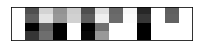

[[   0.      0.      0.      0.  ]
 [  11.63    7.7   239.91   23.34]
 [   0.33    0.22    6.8     5.03]
 [   1.82    1.63 1162.23  722.25]
 [   0.39    0.35    0.      0.  ]
 [  12.05    7.98  248.53   78.83]
 [   0.23    0.15    4.8     1.61]
 [   6.16    5.49    0.      0.  ]
 [   0.13    0.11    0.      0.  ]
 [  34.28   22.7   706.89   96.58]
 [   0.      0.      0.      0.  ]
 [   7.54    6.74    0.      0.  ]
 [   0.      0.      0.      0.  ]]


C:\Users\rautj\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide
C:\Users\rautj\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10


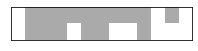

In [52]:
deg=3
ptfi=0.5
mc=np.hstack((SINDyCV_t(polypool_(dxc[:,:].T,deg),Soldt[1:2,:].T,0.01,1e-16,1e-16,0.0,10,ptf=ptfi)
              ,SINDyCV_t(polypool_(dthetac[:,:].T,deg),Soldt[3:4,:].T,0.01,1e-16,1e-16,0.0,10,ptf=ptfi)
              ,SINDyCV_t(polypool_(dxf[:,:].T,deg),Soldt[5:6,:].T,0.01,1e-16,1e-16,0.0,10,ptf=ptfi)
              ,SINDyCV_t(polypool_(dxr[:,:].T,deg),Soldt[7:8,:].T,0.01,1e-16,1e-16,0.0,10,ptf=ptfi)))

plt.figure(figsize=(deg*1,1))
plt.imshow(np.log10(np.abs(mc.T)),cmap='gray_r',aspect='auto',vmin=-1,vmax=2)
plt.tight_layout()
plt.xticks([])
plt.yticks([])
plt.show()

np.set_printoptions(suppress=True)
print(mc.round(2))
np.set_printoptions(suppress=False)
corr=np.nan_to_num(mc/mc)

plt.figure(figsize=(deg*1,1))
plt.imshow(np.log10(np.abs(corr.T)),cmap='gray_r',aspect='auto',vmin=-1,vmax=2)
plt.tight_layout()
plt.xticks([])
plt.yticks([])
plt.show()

In [59]:
#normalisation - noise free
nc=np.abs(Soldt.T).max(axis=0);nSoldt=Soldt.T/nc;nSoldt=nSoldt.T;nSoldtnf=np.copy(nSoldt)

ncdxc=np.abs(dxc.T).max(axis=0);ndxc=dxc.T/ncdxc;ndxc=ndxc.T;ndxcnf=np.copy(ndxc)
ncdthetac=np.abs(dthetac.T).max(axis=0);ndthetac=dthetac.T/ncdthetac;ndthetac=ndthetac.T;ndthetacnf=np.copy(ndthetac)
ncdxf=np.abs(dxf.T).max(axis=0);ndxf=dxf.T/ncdxf;ndxf=ndxf.T;ndxfnf=np.copy(ndxf)
ncdxr=np.abs(dxr.T).max(axis=0);ndxr=dxr.T/ncdxr;ndxr=ndxr.T;ndxrnf=np.copy(ndxr)

#noise addition
nlevel=0.005

for i in range(nSoldt.shape[0]):
    #nSoldt=np.random.normal(nSoldt,nlevel/2)
    nSoldt[i]=nSoldt[i]+nlevel/2*cn(0,len(nSoldt[i]))

for i in range(ndxc.shape[0]):
    #ndxc=np.random.normal(ndxc,nlevel/2)
    ndxc[i]=ndxc[i]+nlevel/2*cn(0,len(ndxc[i]))
for i in range(ndthetac.shape[0]):
    #ndthetac=np.random.normal(ndthetac,nlevel/2)
    ndthetac[i]=ndthetac[i]+nlevel/2*cn(0,len(ndthetac[i]))
for i in range(ndxf.shape[0]):
    #ndxf=np.random.normal(ndxf,nlevel/2)
    ndxf[i]=ndxf[i]+nlevel/2*cn(0,len(ndxf[i]))
for i in range(ndxr.shape[0]):
    #ndxr=np.random.normal(ndxr,nlevel/2)
    ndxr[i]=ndxr[i]+nlevel/2*cn(0,len(ndxr[i]))

#implied noisy measurements - unnormalised
uSoldt=(nSoldt.T*nc).T

udxc=(ndxc.T*ncdxc).T
udthetac=(ndthetac.T*ncdthetac).T
udxf=(ndxf.T*ncdxf).T
udxr=(ndxr.T*ncdxr).T

In [60]:
STSRATE=[]
optthress=[]

thress=np.linspace(0.01,0.4,10)
nlevels=np.linspace(0.0,0.01,11)

for a in tnrange(100):
    stsrate=[]
    optthres=np.nan*np.ones_like(nlevels)
    for inlevel in range(len(nlevels)):
        #normalisation - noise free
        nc=np.abs(Soldt.T).max(axis=0);nSoldt=Soldt.T/nc;nSoldt=nSoldt.T;nSoldtnf=np.copy(nSoldt)

        ncdxc=np.abs(dxc.T).max(axis=0);ndxc=dxc.T/ncdxc;ndxc=ndxc.T;ndxcnf=np.copy(ndxc)
        ncdthetac=np.abs(dthetac.T).max(axis=0);ndthetac=dthetac.T/ncdthetac;ndthetac=ndthetac.T;ndthetacnf=np.copy(ndthetac)
        ncdxf=np.abs(dxf.T).max(axis=0);ndxf=dxf.T/ncdxf;ndxf=ndxf.T;ndxfnf=np.copy(ndxf)
        ncdxr=np.abs(dxr.T).max(axis=0);ndxr=dxr.T/ncdxr;ndxr=ndxr.T;ndxrnf=np.copy(ndxr)

        #noise addition
        nlevel=nlevels[inlevel]

        for i in range(nSoldt.shape[0]):
            #nSoldt=np.random.normal(nSoldt,nlevel/2)
            nSoldt[i]=nSoldt[i]+nlevel/2*cn(0,len(nSoldt[i]))

        for i in range(ndxc.shape[0]):
            #ndxc=np.random.normal(ndxc,nlevel/2)
            ndxc[i]=ndxc[i]+nlevel/2*cn(0,len(ndxc[i]))
        for i in range(ndthetac.shape[0]):
            #ndthetac=np.random.normal(ndthetac,nlevel/2)
            ndthetac[i]=ndthetac[i]+nlevel/2*cn(0,len(ndthetac[i]))
        for i in range(ndxf.shape[0]):
            #ndxf=np.random.normal(ndxf,nlevel/2)
            ndxf[i]=ndxf[i]+nlevel/2*cn(0,len(ndxf[i]))
        for i in range(ndxr.shape[0]):
            #ndxr=np.random.normal(ndxr,nlevel/2)
            ndxr[i]=ndxr[i]+nlevel/2*cn(0,len(ndxr[i]))

        #implied noisy measurements - unnormalised
        uSoldt=(nSoldt.T*nc).T

        udxc=(ndxc.T*ncdxc).T
        udthetac=(ndthetac.T*ncdthetac).T
        udxf=(ndxf.T*ncdxf).T
        udxr=(ndxr.T*ncdxr).T

        success=False
        for ithres in range(len(thress)):
            if not success:
                mc=np.hstack((SINDy(polypool_(udxc[:,:].T,deg),uSoldt[1:2,:].T,thress[ithres],reg=1e-16,normalise='auto'),
                              SINDy(polypool_(udthetac[:,:].T,deg),uSoldt[3:4,:].T,thress[ithres],reg=1e-16,normalise='auto'),
                              SINDy(polypool_(udxf[:,:].T,deg),uSoldt[5:6,:].T,thress[ithres],reg=1e-16,normalise='auto'),
                              SINDy(polypool_(udxr[:,:].T,deg),uSoldt[7:8,:].T,thress[ithres],reg=1e-16,normalise='auto')))
                if np.all(np.nan_to_num(mc/mc)==corr):
                    success=True
                    optthres[inlevel]=thress[ithres]
        stsrate.append(success)
    optthress.append(optthres)
    
    STSRATE.append(stsrate)

C:\Users\rautj\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  import sys


  0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\rautj\Anaconda3\lib\site-packages\ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in true_divide


KeyboardInterrupt: 

In [61]:
#never works
STSRATE=np.array([[False, False, False, False, False, False, False, False, False, False, False]])

In [ ]:
ESRATE=[]

optthres=np.nan_to_num(np.nansum(optthress,axis=0)/np.nansum(np.abs(np.array(optthress)/np.array(optthress)),axis=0), nan=0.35)

for a in tnrange(100):
    esrate=[]
    for inlevel in range(len(nlevels)):
        #print(inlevel)
        #normalisation - noise free
        nc=np.abs(Soldt.T).max(axis=0);nSoldt=Soldt.T/nc;nSoldt=nSoldt.T;nSoldtnf=np.copy(nSoldt)

        ncdxc=np.abs(dxc.T).max(axis=0);ndxc=dxc.T/ncdxc;ndxc=ndxc.T;ndxcnf=np.copy(ndxc)
        ncdthetac=np.abs(dthetac.T).max(axis=0);ndthetac=dthetac.T/ncdthetac;ndthetac=ndthetac.T;ndthetacnf=np.copy(ndthetac)
        ncdxf=np.abs(dxf.T).max(axis=0);ndxf=dxf.T/ncdxf;ndxf=ndxf.T;ndxfnf=np.copy(ndxf)
        ncdxr=np.abs(dxr.T).max(axis=0);ndxr=dxr.T/ncdxr;ndxr=ndxr.T;ndxrnf=np.copy(ndxr)

        #noise addition
        nlevel=nlevels[inlevel]

        for i in range(nSoldt.shape[0]):
            #nSoldt=np.random.normal(nSoldt,nlevel/2)
            nSoldt[i]=nSoldt[i]+nlevel/2*cn(0,len(nSoldt[i]))

        for i in range(ndxc.shape[0]):
            #ndxc=np.random.normal(ndxc,nlevel/2)
            ndxc[i]=ndxc[i]+nlevel/2*cn(0,len(ndxc[i]))
        for i in range(ndthetac.shape[0]):
            #ndthetac=np.random.normal(ndthetac,nlevel/2)
            ndthetac[i]=ndthetac[i]+nlevel/2*cn(0,len(ndthetac[i]))
        for i in range(ndxf.shape[0]):
            #ndxf=np.random.normal(ndxf,nlevel/2)
            ndxf[i]=ndxf[i]+nlevel/2*cn(0,len(ndxf[i]))
        for i in range(ndxr.shape[0]):
            #ndxr=np.random.normal(ndxr,nlevel/2)
            ndxr[i]=ndxr[i]+nlevel/2*cn(0,len(ndxr[i]))

        #implied noisy measurements - unnormalised
        uSoldt=(nSoldt.T*nc).T

        udxc=(ndxc.T*ncdxc).T
        udthetac=(ndthetac.T*ncdthetac).T
        udxf=(ndxf.T*ncdxf).T
        udxr=(ndxr.T*ncdxr).T

        success=False
        for incp in np.arange(0.1,1,0.1):
            #print(incp)
            if not success:
                mc=np.hstack((ESINDy(polypool_(udxc[:,:].T,deg),uSoldt[1:2,:].T,optthres[inlevel],100,0.632,1e-16,incp),
                              ESINDy(polypool_(udthetac[:,:].T,deg),uSoldt[3:4,:].T,optthres[inlevel],100,0.632,1e-16,incp),
                              ESINDy(polypool_(udxf[:,:].T,deg),uSoldt[5:6,:].T,optthres[inlevel],100,0.632,1e-16,incp),
                              ESINDy(polypool_(udxr[:,:].T,deg),uSoldt[7:8,:].T,optthres[inlevel],100,0.632,1e-16,incp)))
                #print(mc)
                if np.all(np.nan_to_num(mc/mc)==corr):
                    success=True
        esrate.append(success)
    
    ESRATE.append(esrate)

In [62]:
#takes really long only works on 0%
ESRATE=np.array([[True, False, False, False, False, False, False, False, False, False, False]])

In [63]:
CVSRATE=[]

ptfs=np.geomspace(0.03,0.05,10)*1
ptfs=np.append([0.4],ptfs)

for a in tnrange(100):
    cvsrate=[]
    for inlevel in range(len(nlevels)):
        #normalisation - noise free
        nc=np.abs(Soldt.T).max(axis=0);nSoldt=Soldt.T/nc;nSoldt=nSoldt.T;nSoldtnf=np.copy(nSoldt)

        ncdxc=np.abs(dxc.T).max(axis=0);ndxc=dxc.T/ncdxc;ndxc=ndxc.T;ndxcnf=np.copy(ndxc)
        ncdthetac=np.abs(dthetac.T).max(axis=0);ndthetac=dthetac.T/ncdthetac;ndthetac=ndthetac.T;ndthetacnf=np.copy(ndthetac)
        ncdxf=np.abs(dxf.T).max(axis=0);ndxf=dxf.T/ncdxf;ndxf=ndxf.T;ndxfnf=np.copy(ndxf)
        ncdxr=np.abs(dxr.T).max(axis=0);ndxr=dxr.T/ncdxr;ndxr=ndxr.T;ndxrnf=np.copy(ndxr)

        #noise addition
        nlevel=nlevels[inlevel]

        for i in range(nSoldt.shape[0]):
            #nSoldt=np.random.normal(nSoldt,nlevel/2)
            nSoldt[i]=nSoldt[i]+nlevel/2*cn(0,len(nSoldt[i]))

        for i in range(ndxc.shape[0]):
            #ndxc=np.random.normal(ndxc,nlevel/2)
            ndxc[i]=ndxc[i]+nlevel/2*cn(0,len(ndxc[i]))
        for i in range(ndthetac.shape[0]):
            #ndthetac=np.random.normal(ndthetac,nlevel/2)
            ndthetac[i]=ndthetac[i]+nlevel/2*cn(0,len(ndthetac[i]))
        for i in range(ndxf.shape[0]):
            #ndxf=np.random.normal(ndxf,nlevel/2)
            ndxf[i]=ndxf[i]+nlevel/2*cn(0,len(ndxf[i]))
        for i in range(ndxr.shape[0]):
            #ndxr=np.random.normal(ndxr,nlevel/2)
            ndxr[i]=ndxr[i]+nlevel/2*cn(0,len(ndxr[i]))

        #implied noisy measurements - unnormalised
        uSoldt=(nSoldt.T*nc).T

        udxc=(ndxc.T*ncdxc).T
        udthetac=(ndthetac.T*ncdthetac).T
        udxf=(ndxf.T*ncdxf).T
        udxr=(ndxr.T*ncdxr).T

        success=False
        for iptf in range(len(ptfs)):
            ptfi=ptfs[iptf]
            if not success:
                mc=np.hstack((SINDyCV_t(polypool_(udxc[:,:].T,deg),uSoldt[1:2,:].T,0.01,1e-16,1e-16,0.0,10,ptf=ptfi),
                              SINDyCV_t(polypool_(udthetac[:,:].T,deg),uSoldt[3:4,:].T,0.01,1e-16,1e-16,0.0,10,ptf=ptfi),
                              SINDyCV_t(polypool_(udxf[:,:].T,deg),uSoldt[5:6,:].T,0.01,1e-16,1e-16,0.0,10,ptf=ptfi),
                              SINDyCV_t(polypool_(udxr[:,:].T,deg),uSoldt[7:8,:].T,0.01,1e-16,1e-16,0.0,10,ptf=ptfi)))
                if np.all(np.nan_to_num(mc/mc)==corr):
                    success=True
        cvsrate.append(success)
    
    CVSRATE.append(cvsrate)

C:\Users\rautj\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  


  0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\rautj\Anaconda3\lib\site-packages\ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in true_divide


In [64]:
CVSTSRATE=[]

for a in tnrange(100):
    cvstsrate=[]
    for inlevel in range(len(nlevels)):
        #normalisation - noise free
        nc=np.abs(Soldt.T).max(axis=0);nSoldt=Soldt.T/nc;nSoldt=nSoldt.T;nSoldtnf=np.copy(nSoldt)

        ncdxc=np.abs(dxc.T).max(axis=0);ndxc=dxc.T/ncdxc;ndxc=ndxc.T;ndxcnf=np.copy(ndxc)
        ncdthetac=np.abs(dthetac.T).max(axis=0);ndthetac=dthetac.T/ncdthetac;ndthetac=ndthetac.T;ndthetacnf=np.copy(ndthetac)
        ncdxf=np.abs(dxf.T).max(axis=0);ndxf=dxf.T/ncdxf;ndxf=ndxf.T;ndxfnf=np.copy(ndxf)
        ncdxr=np.abs(dxr.T).max(axis=0);ndxr=dxr.T/ncdxr;ndxr=ndxr.T;ndxrnf=np.copy(ndxr)

        #noise addition
        nlevel=nlevels[inlevel]

        for i in range(nSoldt.shape[0]):
            #nSoldt=np.random.normal(nSoldt,nlevel/2)
            nSoldt[i]=nSoldt[i]+nlevel/2*cn(0,len(nSoldt[i]))

        for i in range(ndxc.shape[0]):
            #ndxc=np.random.normal(ndxc,nlevel/2)
            ndxc[i]=ndxc[i]+nlevel/2*cn(0,len(ndxc[i]))
        for i in range(ndthetac.shape[0]):
            #ndthetac=np.random.normal(ndthetac,nlevel/2)
            ndthetac[i]=ndthetac[i]+nlevel/2*cn(0,len(ndthetac[i]))
        for i in range(ndxf.shape[0]):
            #ndxf=np.random.normal(ndxf,nlevel/2)
            ndxf[i]=ndxf[i]+nlevel/2*cn(0,len(ndxf[i]))
        for i in range(ndxr.shape[0]):
            #ndxr=np.random.normal(ndxr,nlevel/2)
            ndxr[i]=ndxr[i]+nlevel/2*cn(0,len(ndxr[i]))

        #implied noisy measurements - unnormalised
        uSoldt=(nSoldt.T*nc).T

        udxc=(ndxc.T*ncdxc).T
        udthetac=(ndthetac.T*ncdthetac).T
        udxf=(ndxf.T*ncdxf).T
        udxr=(ndxr.T*ncdxr).T

        success=False
        pen=1e-4
        for iptf in range(len(ptfs)):
            ptfi=ptfs[iptf]
            if not success:
                mc0=np.hstack((SINDyCV_t(polypool_(udxc[:,:].T,deg),uSoldt[1:2,:].T,0.01,pen,pen,0.0,10,ptf=ptfi),
                               SINDyCV_t(polypool_(udthetac[:,:].T,deg),uSoldt[3:4,:].T,0.01,pen,pen,0.0,10,ptf=ptfi),
                               SINDyCV_t(polypool_(udxf[:,:].T,deg),uSoldt[5:6,:].T,0.01,pen,pen,0.0,10,ptf=ptfi),
                               SINDyCV_t(polypool_(udxr[:,:].T,deg),uSoldt[7:8,:].T,0.01,pen,pen,0.0,10,ptf=ptfi)))
                for ithres in range(len(thress)):
                    mc=np.hstack((re_SINDy(polypool_(udxc[:,:].T,deg),uSoldt[1:2,:].T,copy.deepcopy(mc0[:,0:1]),thress[ithres],reg=1e-16,normalise='auto'),
                                  re_SINDy(polypool_(udthetac[:,:].T,deg),uSoldt[3:4,:].T,copy.deepcopy(mc0[:,1:2]),thress[ithres],reg=1e-16,normalise='auto'),
                                  re_SINDy(polypool_(udxf[:,:].T,deg),uSoldt[5:6,:].T,copy.deepcopy(mc0[:,2:3]),thress[ithres],reg=1e-16,normalise='auto'),
                                  re_SINDy(polypool_(udxr[:,:].T,deg),uSoldt[7:8,:].T,copy.deepcopy(mc0[:,3:4]),thress[ithres],reg=1e-16,normalise='auto')))
                    if np.all(np.nan_to_num(mc/mc)==corr):
                        success=True
        cvstsrate.append(success)
    
    CVSTSRATE.append(cvstsrate)

C:\Users\rautj\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  This is separate from the ipykernel package so we can avoid doing imports until


  0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\rautj\Anaconda3\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in true_divide


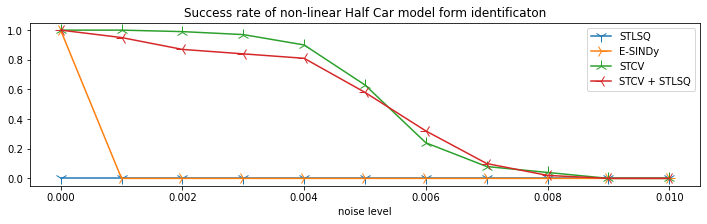

In [65]:
plt.figure(figsize=(12,3))
plt.title('Success rate of non-linear Half Car model form identificaton')
plt.xlabel('noise level')
plt.plot(nlevels,np.average(np.array(STSRATE),axis=0),'1-',markersize=12,label='STLSQ')
plt.plot(nlevels,np.average(np.array(ESRATE),axis=0),'4-',markersize=12,label='E-SINDy')
plt.plot(nlevels,np.average(np.array(CVSRATE),axis=0),'2-',markersize=12,label='STCV')
plt.plot(nlevels,np.average(np.array(CVSTSRATE),axis=0),'3-',markersize=12,label='STCV + STLSQ')
plt.legend()
plt.show()

In [66]:
np.vstack((np.average(np.array(STSRATE),axis=0),np.average(np.array(ESRATE),axis=0),np.average(np.array(CVSRATE),axis=0),np.average(np.array(CVSTSRATE),axis=0)))

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [1.  , 1.  , 0.99, 0.97, 0.9 , 0.63, 0.24, 0.08, 0.04, 0.  , 0.  ],
       [1.  , 0.95, 0.87, 0.84, 0.81, 0.58, 0.32, 0.1 , 0.02, 0.  , 0.  ]])

In [67]:
#np.savetxt('nlinearcar.stcv',np.vstack((np.average(np.array(STSRATE),axis=0),np.average(np.array(ESRATE),axis=0),np.average(np.array(CVSRATE),axis=0),np.average(np.array(CVSTSRATE),axis=0))))

In [68]:
np.loadtxt('nlinearcar.stcv')

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [1.  , 1.  , 0.99, 0.97, 0.9 , 0.63, 0.24, 0.08, 0.04, 0.  , 0.  ],
       [1.  , 0.95, 0.87, 0.84, 0.81, 0.58, 0.32, 0.1 , 0.02, 0.  , 0.  ]])

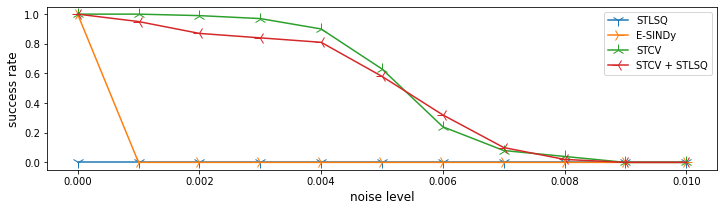

In [69]:
plt.figure(figsize=(12,3))
plt.ylabel('success rate',fontsize=12)
plt.xlabel('noise level',fontsize=12)
plt.plot(nlevels,np.loadtxt('nlinearcar.stcv')[0],'1-',markersize=12,label='STLSQ')
plt.plot(nlevels,np.loadtxt('nlinearcar.stcv')[1],'4-',markersize=12,label='E-SINDy')
plt.plot(nlevels,np.loadtxt('nlinearcar.stcv')[2],'2-',markersize=12,label='STCV')
plt.plot(nlevels,np.loadtxt('nlinearcar.stcv')[3],'3-',markersize=12,label='STCV + STLSQ')
#plt.xticks(nlevels[::2],['']*6)
plt.legend()
plt.show()

In [ ]:
#non-linear car - normalised

In [70]:
#normalisation - noise free
nc=np.abs(Soldt.T).max(axis=0);nSoldt=Soldt.T/nc;nSoldt=nSoldt.T;nSoldtnf=np.copy(nSoldt)

ncdxc=np.abs(dxc.T).max(axis=0);ndxc=dxc.T/ncdxc;ndxc=ndxc.T;ndxcnf=np.copy(ndxc)
ncdthetac=np.abs(dthetac.T).max(axis=0);ndthetac=dthetac.T/ncdthetac;ndthetac=ndthetac.T;ndthetacnf=np.copy(ndthetac)
ncdxf=np.abs(dxf.T).max(axis=0);ndxf=dxf.T/ncdxf;ndxf=ndxf.T;ndxfnf=np.copy(ndxf)
ncdxr=np.abs(dxr.T).max(axis=0);ndxr=dxr.T/ncdxr;ndxr=ndxr.T;ndxrnf=np.copy(ndxr)

#noise addition
nlevel=0.006

for i in range(nSoldt.shape[0]):
    #nSoldt=np.random.normal(nSoldt,nlevel/2)
    nSoldt[i]=nSoldt[i]+nlevel/2*cn(0,len(nSoldt[i]))

for i in range(ndxc.shape[0]):
    #ndxc=np.random.normal(ndxc,nlevel/2)
    ndxc[i]=ndxc[i]+nlevel/2*cn(0,len(ndxc[i]))
for i in range(ndthetac.shape[0]):
    #ndthetac=np.random.normal(ndthetac,nlevel/2)
    ndthetac[i]=ndthetac[i]+nlevel/2*cn(0,len(ndthetac[i]))
for i in range(ndxf.shape[0]):
    #ndxf=np.random.normal(ndxf,nlevel/2)
    ndxf[i]=ndxf[i]+nlevel/2*cn(0,len(ndxf[i]))
for i in range(ndxr.shape[0]):
    #ndxr=np.random.normal(ndxr,nlevel/2)
    ndxr[i]=ndxr[i]+nlevel/2*cn(0,len(ndxr[i]))

#implied noisy measurements - unnormalised
uSoldt=(nSoldt.T*nc).T

udxc=(ndxc.T*ncdxc).T
udthetac=(ndthetac.T*ncdthetac).T
udxf=(ndxf.T*ncdxf).T
udxr=(ndxr.T*ncdxr).T

In [71]:
STSRATE=[]
optthress=[]

thress=thress=np.linspace(0.0001,0.0028,10)
nlevels=np.linspace(0.0,0.01,11)

for a in tnrange(100):
    stsrate=[]
    optthres=np.nan*np.ones_like(nlevels)
    for inlevel in range(len(nlevels)):
        #normalisation - noise free
        nc=np.abs(Soldt.T).max(axis=0);nSoldt=Soldt.T/nc;nSoldt=nSoldt.T;nSoldtnf=np.copy(nSoldt)

        ncdxc=np.abs(dxc.T).max(axis=0);ndxc=dxc.T/ncdxc;ndxc=ndxc.T;ndxcnf=np.copy(ndxc)
        ncdthetac=np.abs(dthetac.T).max(axis=0);ndthetac=dthetac.T/ncdthetac;ndthetac=ndthetac.T;ndthetacnf=np.copy(ndthetac)
        ncdxf=np.abs(dxf.T).max(axis=0);ndxf=dxf.T/ncdxf;ndxf=ndxf.T;ndxfnf=np.copy(ndxf)
        ncdxr=np.abs(dxr.T).max(axis=0);ndxr=dxr.T/ncdxr;ndxr=ndxr.T;ndxrnf=np.copy(ndxr)

        #noise addition
        nlevel=nlevels[inlevel]

        for i in range(nSoldt.shape[0]):
            #nSoldt=np.random.normal(nSoldt,nlevel/2)
            nSoldt[i]=nSoldt[i]+nlevel/2*cn(0,len(nSoldt[i]))

        for i in range(ndxc.shape[0]):
            #ndxc=np.random.normal(ndxc,nlevel/2)
            ndxc[i]=ndxc[i]+nlevel/2*cn(0,len(ndxc[i]))
        for i in range(ndthetac.shape[0]):
            #ndthetac=np.random.normal(ndthetac,nlevel/2)
            ndthetac[i]=ndthetac[i]+nlevel/2*cn(0,len(ndthetac[i]))
        for i in range(ndxf.shape[0]):
            #ndxf=np.random.normal(ndxf,nlevel/2)
            ndxf[i]=ndxf[i]+nlevel/2*cn(0,len(ndxf[i]))
        for i in range(ndxr.shape[0]):
            #ndxr=np.random.normal(ndxr,nlevel/2)
            ndxr[i]=ndxr[i]+nlevel/2*cn(0,len(ndxr[i]))

        #implied noisy measurements - unnormalised
        uSoldt=(nSoldt.T*nc).T

        udxc=(ndxc.T*ncdxc).T
        udthetac=(ndthetac.T*ncdthetac).T
        udxf=(ndxf.T*ncdxf).T
        udxr=(ndxr.T*ncdxr).T

        success=False
        for ithres in range(len(thress)):
            if not success:
                mc=np.hstack((SINDy(polypool_(ndxc[:,:].T,deg),nSoldt[1:2,:].T,thress[ithres],reg=1e-16,normalise='auto'),
                              SINDy(polypool_(ndthetac[:,:].T,deg),nSoldt[3:4,:].T,thress[ithres],reg=1e-16,normalise='auto'),
                              SINDy(polypool_(ndxf[:,:].T,deg),nSoldt[5:6,:].T,thress[ithres],reg=1e-16,normalise='auto'),
                              SINDy(polypool_(ndxr[:,:].T,deg),nSoldt[7:8,:].T,thress[ithres],reg=1e-16,normalise='auto')))
                if np.all(np.nan_to_num(mc/mc)==corr):
                    success=True
                    optthres[inlevel]=thress[ithres]
        stsrate.append(success)
    optthress.append(optthres)
    
    STSRATE.append(stsrate)

C:\Users\rautj\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  import sys


  0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\rautj\Anaconda3\lib\site-packages\ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in true_divide


In [72]:
ESRATE=[]

optthres=np.nan_to_num(np.nansum(optthress,axis=0)/np.nansum(np.abs(np.array(optthress)/np.array(optthress)),axis=0), nan=0.002)

for a in tnrange(100):
    esrate=[]
    for inlevel in range(len(nlevels)):
        #print(inlevel)
        #normalisation - noise free
        nc=np.abs(Soldt.T).max(axis=0);nSoldt=Soldt.T/nc;nSoldt=nSoldt.T;nSoldtnf=np.copy(nSoldt)

        ncdxc=np.abs(dxc.T).max(axis=0);ndxc=dxc.T/ncdxc;ndxc=ndxc.T;ndxcnf=np.copy(ndxc)
        ncdthetac=np.abs(dthetac.T).max(axis=0);ndthetac=dthetac.T/ncdthetac;ndthetac=ndthetac.T;ndthetacnf=np.copy(ndthetac)
        ncdxf=np.abs(dxf.T).max(axis=0);ndxf=dxf.T/ncdxf;ndxf=ndxf.T;ndxfnf=np.copy(ndxf)
        ncdxr=np.abs(dxr.T).max(axis=0);ndxr=dxr.T/ncdxr;ndxr=ndxr.T;ndxrnf=np.copy(ndxr)

        #noise addition
        nlevel=nlevels[inlevel]

        for i in range(nSoldt.shape[0]):
            #nSoldt=np.random.normal(nSoldt,nlevel/2)
            nSoldt[i]=nSoldt[i]+nlevel/2*cn(0,len(nSoldt[i]))

        for i in range(ndxc.shape[0]):
            #ndxc=np.random.normal(ndxc,nlevel/2)
            ndxc[i]=ndxc[i]+nlevel/2*cn(0,len(ndxc[i]))
        for i in range(ndthetac.shape[0]):
            #ndthetac=np.random.normal(ndthetac,nlevel/2)
            ndthetac[i]=ndthetac[i]+nlevel/2*cn(0,len(ndthetac[i]))
        for i in range(ndxf.shape[0]):
            #ndxf=np.random.normal(ndxf,nlevel/2)
            ndxf[i]=ndxf[i]+nlevel/2*cn(0,len(ndxf[i]))
        for i in range(ndxr.shape[0]):
            #ndxr=np.random.normal(ndxr,nlevel/2)
            ndxr[i]=ndxr[i]+nlevel/2*cn(0,len(ndxr[i]))

        #implied noisy measurements - unnormalised
        uSoldt=(nSoldt.T*nc).T

        udxc=(ndxc.T*ncdxc).T
        udthetac=(ndthetac.T*ncdthetac).T
        udxf=(ndxf.T*ncdxf).T
        udxr=(ndxr.T*ncdxr).T

        success=False
        for incp in np.arange(0.1,1,0.1):
            #print(incp)
            if not success:
                mc=np.hstack((ESINDy(polypool_(ndxc[:,:].T,deg),nSoldt[1:2,:].T,optthres[inlevel],100,0.632,1e-16,incp),
                              ESINDy(polypool_(ndthetac[:,:].T,deg),nSoldt[3:4,:].T,optthres[inlevel],100,0.632,1e-16,incp),
                              ESINDy(polypool_(ndxf[:,:].T,deg),nSoldt[5:6,:].T,optthres[inlevel],100,0.632,1e-16,incp),
                              ESINDy(polypool_(ndxr[:,:].T,deg),nSoldt[7:8,:].T,optthres[inlevel],100,0.632,1e-16,incp)))
                #print(mc)
                if np.all(np.nan_to_num(mc/mc)==corr):
                    success=True
        esrate.append(success)
    
    ESRATE.append(esrate)

C:\Users\rautj\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\rautj\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  """


  0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\rautj\Anaconda3\lib\site-packages\ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in true_divide


In [73]:
CVSRATE=[]

ptfs=np.geomspace(0.03,0.05,10)*1
ptfs=np.append([0.4],ptfs)

for a in tnrange(100):
    cvsrate=[]
    for inlevel in range(len(nlevels)):
        #normalisation - noise free
        nc=np.abs(Soldt.T).max(axis=0);nSoldt=Soldt.T/nc;nSoldt=nSoldt.T;nSoldtnf=np.copy(nSoldt)

        ncdxc=np.abs(dxc.T).max(axis=0);ndxc=dxc.T/ncdxc;ndxc=ndxc.T;ndxcnf=np.copy(ndxc)
        ncdthetac=np.abs(dthetac.T).max(axis=0);ndthetac=dthetac.T/ncdthetac;ndthetac=ndthetac.T;ndthetacnf=np.copy(ndthetac)
        ncdxf=np.abs(dxf.T).max(axis=0);ndxf=dxf.T/ncdxf;ndxf=ndxf.T;ndxfnf=np.copy(ndxf)
        ncdxr=np.abs(dxr.T).max(axis=0);ndxr=dxr.T/ncdxr;ndxr=ndxr.T;ndxrnf=np.copy(ndxr)

        #noise addition
        nlevel=nlevels[inlevel]

        for i in range(nSoldt.shape[0]):
            #nSoldt=np.random.normal(nSoldt,nlevel/2)
            nSoldt[i]=nSoldt[i]+nlevel/2*cn(0,len(nSoldt[i]))

        for i in range(ndxc.shape[0]):
            #ndxc=np.random.normal(ndxc,nlevel/2)
            ndxc[i]=ndxc[i]+nlevel/2*cn(0,len(ndxc[i]))
        for i in range(ndthetac.shape[0]):
            #ndthetac=np.random.normal(ndthetac,nlevel/2)
            ndthetac[i]=ndthetac[i]+nlevel/2*cn(0,len(ndthetac[i]))
        for i in range(ndxf.shape[0]):
            #ndxf=np.random.normal(ndxf,nlevel/2)
            ndxf[i]=ndxf[i]+nlevel/2*cn(0,len(ndxf[i]))
        for i in range(ndxr.shape[0]):
            #ndxr=np.random.normal(ndxr,nlevel/2)
            ndxr[i]=ndxr[i]+nlevel/2*cn(0,len(ndxr[i]))

        #implied noisy measurements - unnormalised
        uSoldt=(nSoldt.T*nc).T

        udxc=(ndxc.T*ncdxc).T
        udthetac=(ndthetac.T*ncdthetac).T
        udxf=(ndxf.T*ncdxf).T
        udxr=(ndxr.T*ncdxr).T

        success=False
        for iptf in range(len(ptfs)):
            ptfi=ptfs[iptf]
            if not success:
                mc=np.hstack((SINDyCV_t(polypool_(ndxc[:,:].T,deg),nSoldt[1:2,:].T,0.0001,1e-16,1e-16,0.0,10,ptf=ptfi),
                              SINDyCV_t(polypool_(ndthetac[:,:].T,deg),nSoldt[3:4,:].T,0.0001,1e-16,1e-16,0.0,10,ptf=ptfi),
                              SINDyCV_t(polypool_(ndxf[:,:].T,deg),nSoldt[5:6,:].T,0.0001,1e-16,1e-16,0.0,10,ptf=ptfi),
                              SINDyCV_t(polypool_(ndxr[:,:].T,deg),nSoldt[7:8,:].T,0.0001,1e-16,1e-16,0.0,10,ptf=ptfi)))
                if np.all(np.nan_to_num(mc/mc)==corr):
                    success=True
        cvsrate.append(success)
    
    CVSRATE.append(cvsrate)

C:\Users\rautj\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  


  0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\rautj\Anaconda3\lib\site-packages\ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in true_divide


In [74]:
CVSTSRATE=[]

for a in tnrange(100):
    cvstsrate=[]
    for inlevel in range(len(nlevels)):
        #normalisation - noise free
        nc=np.abs(Soldt.T).max(axis=0);nSoldt=Soldt.T/nc;nSoldt=nSoldt.T;nSoldtnf=np.copy(nSoldt)

        ncdxc=np.abs(dxc.T).max(axis=0);ndxc=dxc.T/ncdxc;ndxc=ndxc.T;ndxcnf=np.copy(ndxc)
        ncdthetac=np.abs(dthetac.T).max(axis=0);ndthetac=dthetac.T/ncdthetac;ndthetac=ndthetac.T;ndthetacnf=np.copy(ndthetac)
        ncdxf=np.abs(dxf.T).max(axis=0);ndxf=dxf.T/ncdxf;ndxf=ndxf.T;ndxfnf=np.copy(ndxf)
        ncdxr=np.abs(dxr.T).max(axis=0);ndxr=dxr.T/ncdxr;ndxr=ndxr.T;ndxrnf=np.copy(ndxr)

        #noise addition
        nlevel=nlevels[inlevel]

        for i in range(nSoldt.shape[0]):
            #nSoldt=np.random.normal(nSoldt,nlevel/2)
            nSoldt[i]=nSoldt[i]+nlevel/2*cn(0,len(nSoldt[i]))

        for i in range(ndxc.shape[0]):
            #ndxc=np.random.normal(ndxc,nlevel/2)
            ndxc[i]=ndxc[i]+nlevel/2*cn(0,len(ndxc[i]))
        for i in range(ndthetac.shape[0]):
            #ndthetac=np.random.normal(ndthetac,nlevel/2)
            ndthetac[i]=ndthetac[i]+nlevel/2*cn(0,len(ndthetac[i]))
        for i in range(ndxf.shape[0]):
            #ndxf=np.random.normal(ndxf,nlevel/2)
            ndxf[i]=ndxf[i]+nlevel/2*cn(0,len(ndxf[i]))
        for i in range(ndxr.shape[0]):
            #ndxr=np.random.normal(ndxr,nlevel/2)
            ndxr[i]=ndxr[i]+nlevel/2*cn(0,len(ndxr[i]))

        #implied noisy measurements - unnormalised
        uSoldt=(nSoldt.T*nc).T

        udxc=(ndxc.T*ncdxc).T
        udthetac=(ndthetac.T*ncdthetac).T
        udxf=(ndxf.T*ncdxf).T
        udxr=(ndxr.T*ncdxr).T

        success=False
        pen=1e-4
        for iptf in range(len(ptfs)):
            ptfi=ptfs[iptf]
            if not success:
                mc0=np.hstack((SINDyCV_t(polypool_(ndxc[:,:].T,deg),nSoldt[1:2,:].T,0.0001,pen,pen,0.0,10,ptf=ptfi),
                               SINDyCV_t(polypool_(ndthetac[:,:].T,deg),nSoldt[3:4,:].T,0.0001,pen,pen,0.0,10,ptf=ptfi),
                               SINDyCV_t(polypool_(ndxf[:,:].T,deg),nSoldt[5:6,:].T,0.0001,pen,pen,0.0,10,ptf=ptfi),
                               SINDyCV_t(polypool_(ndxr[:,:].T,deg),nSoldt[7:8,:].T,0.0001,pen,pen,0.0,10,ptf=ptfi)))
                for ithres in range(len(thress)):
                    mc=np.hstack((re_SINDy(polypool_(ndxc[:,:].T,deg),nSoldt[1:2,:].T,copy.deepcopy(mc0[:,0:1]),thress[ithres],reg=1e-16,normalise='auto'),
                                  re_SINDy(polypool_(ndthetac[:,:].T,deg),nSoldt[3:4,:].T,copy.deepcopy(mc0[:,1:2]),thress[ithres],reg=1e-16,normalise='auto'),
                                  re_SINDy(polypool_(ndxf[:,:].T,deg),nSoldt[5:6,:].T,copy.deepcopy(mc0[:,2:3]),thress[ithres],reg=1e-16,normalise='auto'),
                                  re_SINDy(polypool_(ndxr[:,:].T,deg),nSoldt[7:8,:].T,copy.deepcopy(mc0[:,3:4]),thress[ithres],reg=1e-16,normalise='auto')))
                    if np.all(np.nan_to_num(mc/mc)==corr):
                        success=True
        cvstsrate.append(success)
    
    CVSTSRATE.append(cvstsrate)

C:\Users\rautj\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  This is separate from the ipykernel package so we can avoid doing imports until


  0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\rautj\Anaconda3\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in true_divide


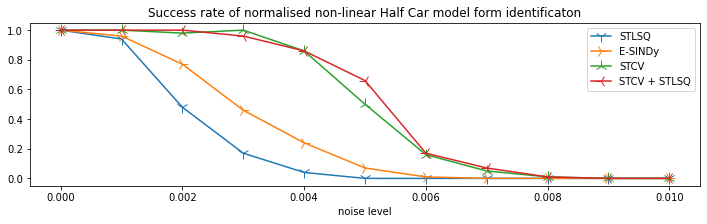

In [75]:
plt.figure(figsize=(12,3))
plt.title('Success rate of normalised non-linear Half Car model form identificaton')
plt.xlabel('noise level')
plt.plot(nlevels,np.average(np.array(STSRATE),axis=0),'1-',markersize=12,label='STLSQ')
plt.plot(nlevels,np.average(np.array(ESRATE),axis=0),'4-',markersize=12,label='E-SINDy')
plt.plot(nlevels,np.average(np.array(CVSRATE),axis=0),'2-',markersize=12,label='STCV')
plt.plot(nlevels,np.average(np.array(CVSTSRATE),axis=0),'3-',markersize=12,label='STCV + STLSQ')
plt.legend()
plt.show()

In [76]:
np.vstack((np.average(np.array(STSRATE),axis=0),np.average(np.array(ESRATE),axis=0),np.average(np.array(CVSRATE),axis=0),np.average(np.array(CVSTSRATE),axis=0)))

array([[1.  , 0.94, 0.48, 0.17, 0.04, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [1.  , 0.96, 0.77, 0.46, 0.24, 0.07, 0.01, 0.  , 0.  , 0.  , 0.  ],
       [1.  , 1.  , 0.98, 1.  , 0.86, 0.5 , 0.16, 0.05, 0.01, 0.  , 0.  ],
       [1.  , 1.  , 1.  , 0.96, 0.86, 0.66, 0.17, 0.07, 0.01, 0.  , 0.  ]])

In [77]:
#np.savetxt('nlinearcarnorm.stcv',np.vstack((np.average(np.array(STSRATE),axis=0),np.average(np.array(ESRATE),axis=0),np.average(np.array(CVSRATE),axis=0),np.average(np.array(CVSTSRATE),axis=0))))

In [78]:
np.loadtxt('nlinearcarnorm.stcv')

array([[1.  , 0.94, 0.48, 0.17, 0.04, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [1.  , 0.96, 0.77, 0.46, 0.24, 0.07, 0.01, 0.  , 0.  , 0.  , 0.  ],
       [1.  , 1.  , 0.98, 1.  , 0.86, 0.5 , 0.16, 0.05, 0.01, 0.  , 0.  ],
       [1.  , 1.  , 1.  , 0.96, 0.86, 0.66, 0.17, 0.07, 0.01, 0.  , 0.  ]])

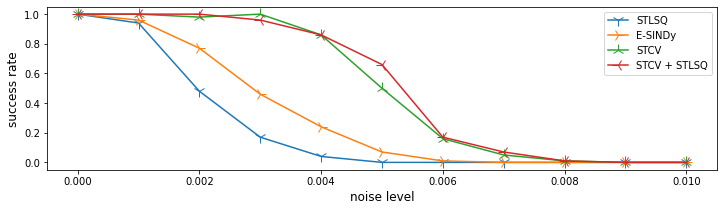

In [79]:
plt.figure(figsize=(12,3))
plt.ylabel('success rate',fontsize=12)
plt.xlabel('noise level',fontsize=12)
plt.plot(nlevels,np.loadtxt('nlinearcarnorm.stcv')[0],'1-',markersize=12,label='STLSQ')
plt.plot(nlevels,np.loadtxt('nlinearcarnorm.stcv')[1],'4-',markersize=12,label='E-SINDy')
plt.plot(nlevels,np.loadtxt('nlinearcarnorm.stcv')[2],'2-',markersize=12,label='STCV')
plt.plot(nlevels,np.loadtxt('nlinearcarnorm.stcv')[3],'3-',markersize=12,label='STCV + STLSQ')
#plt.xticks(nlevels[::2],['']*6)
plt.legend()
plt.show()